In [2]:
!pip install Unidecode

     |████████████████████████████████| 245kB 5.7MB/s 


In [42]:
import ee
import time
import sys
from unidecode import unidecode
import argparse
import os.path
import matplotlib.pyplot as plt
import numpy as np
import cv2
from random import random
import csv
try:
    from google.colab.patches import cv2_imshow
except:
    from cv2 import imshow as cv2_imshow


In [4]:
#initialize google earth engine
try:
  ee.Initialize()
except:
  ee.Authenticate()
  ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=prtxkJBsShpI9mShRr-XrqTd8-xPOmRuXqtcAKfiJL8&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AY0e-g6lcdyLJlnPSMWfNpgK7op8avhxsp4a_CeTHBLQ_6W4LyGrh26xz1E

Successfully saved authorization token.


# Global variables

In [17]:
# name of GEE collections:
IMG_COLLECTIONS = ['MODIS/006/MOD09A1', 'MODIS/006/MYD11A2', 'MODIS/006/MCD12Q1', 'LANDSAT/LC08/C01/T1_TOA', 'LANDSAT/LC08/C01/T1_8DAY_NDVI', 'COPERNICUS/Landcover/100m/Proba-V-C3/Global']
# Images codes -- description
IMG_COLLECTION_CODES = ['reflectance', 'Temperature', 'cover', 'rgb', 'NDVI', 'COPERNICUS_Landcover']

# Data range to be downloaded for each collection
# MAKE SURE the dates are in the date range of the GEE layer (check on GEE website)
IMG_START_DATES = ['2014-01-01', '2014-01-01', '2017-01-01', '2017-01-01', '2017-01-01', '2018-01-01']
IMG_END_DATES = ['2015-01-01', '2015-01-01', '2018-01-01', '2018-01-01', '2018-01-01', '2019-01-01']

# Bands that will be selected in each collection
IMG_COLLECTION_BANDS = [['sur_refl_b01', 'sur_refl_b02', 'sur_refl_b03', 'sur_refl_b04', 'sur_refl_b05', 'sur_refl_b06', 'sur_refl_b07'], 
                        ['LST_Day_1km', 'LST_Night_1km'], ['LC_Type1'], ['B4', 'B3', 'B2'], ['NDVI'], ['discrete_classification']]


# Ranges for plotting images (debug mode = True)                      
IMG_COLLECTION_MIN = [-100.0, 14000.0, 17.0, 0.0, 0.0, 0.0]
IMG_COLLECTION_MAX = [3000.0, 16000.0, 1.0, 0.4, 1.0, 20.0]
CLEAN_NAME = lambda r, l: unidecode(r.get('properties').get(l)).lower().translate("'()/&-").strip()

# Functions

In [18]:
def export_to_cloud(img, fname, folder, expregion, eeuser=None, scale=10):
  task = ee.batch.Export.image.toDrive(**{
      'image': img.clip(expregion),
      'description':fname, 
      'folder':folder, 
      'fileNamePrefix':fname, 
      'dimensions':None, 
      'region':expregion.geometry().bounds().getInfo()['coordinates'],
      'scale':scale, 
      'crs':'EPSG:4326', 
      'crsTransform':None, 
      'maxPixels':1e13
  })
  task.start()
  while task.status()['state'] == 'RUNNING':
    print('Running...')
    time.sleep(20)
  print('Done.'.format(task.status()))
  time.sleep(10)

In [19]:
def appendBand(current, previous):
    # Rename the band
    previous=ee.Image(previous)
    current = current.select(IMG_COLLECTION_BANDS[img_collection_index])
    # Append it to the result (Note: only return current item on first element/iteration)
    accum = ee.Algorithms.If(ee.Algorithms.IsEqual(previous,None), current, previous.addBands(ee.Image(current)))
    # Return the accumulation
    return accum


In [117]:
def export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=False, scale=100):
    img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
    image_collection = IMG_COLLECTIONS[img_collection_index]
    start_date = IMG_START_DATES[img_collection_index]
    end_date = IMG_END_DATES[img_collection_index]
    county_region = ee.FeatureCollection(ftr_collection)

    feature_list = county_region.toList(1e5)
    feature_list_computed = feature_list.getInfo()

    # Get ImageCollection
    imgcoll = ee.ImageCollection(image_collection) \
      .filterDate(start_date,end_date)\
      # .filterBounds(ee.Geometry.Rectangle(boundary_filter));  #focus on a rectangle around Senegal
        
    # appends timestamps into bands
    img=imgcoll.iterate(appendBand)
    img=ee.Image(img)
    totalImages = imgcoll.size().getInfo()
    print("Total count of images in the collection:{} for the date range: {} - {}".format(totalImages, start_date, end_date))

    for idx, region in enumerate(feature_list_computed):
      subunit_key = ftr_key_fn(region)

      if debug:
        for i in range(1): #ONLY PLOT 2 first images (Timestamps)
          first_image = ee.Image(imgcoll.toList(imgcoll.size()).get(i))
          bands = IMG_COLLECTION_BANDS[img_collection_index][0] #visualize only first band
          plotROI(first_image, ee.Feature(region),debug=debug, 
                  bands=bands, max=IMG_COLLECTION_MAX[img_collection_index])
      file_name = country + '_' + collection_name + '_' + subunit_key.replace('/', '_') + "_" + start_date + "_" + end_date
      print(file_name)
      print(idx)
      folder_name = os.path.join(folder_name_drive, collection_name)
      export_to_cloud(img, file_name, folder_name, ee.Feature(region), scale=scale)
      if only_download_first_image:
        break #only first image 

In [121]:
def export_images_collection_ROI_lat_long(squares, names, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=False, scale=100):
    img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
    image_collection = IMG_COLLECTIONS[img_collection_index]
    start_date = IMG_START_DATES[img_collection_index]
    end_date = IMG_END_DATES[img_collection_index]
    for idx in range(len(squares)):
      square = squares[idx]
      county_region = ee.FeatureCollection(square)

      feature_list = county_region.toList(1e5)
      feature_list_computed = feature_list.getInfo()

      # Get ImageCollection
      imgcoll = ee.ImageCollection(image_collection) \
        .filterDate(start_date,end_date)\
          
      # appends timestamps into bands
      img=imgcoll.iterate(appendBand)
      img=ee.Image(img)
      totalImages = imgcoll.size().getInfo()
      print("Total count of images in the collection:{} for the date range: {} - {}".format(totalImages, start_date, end_date))

      # for idx, region in enumerate(feature_list_computed):
        # subunit_key = ftr_key_fn(region)
      if debug:
        for i in range(1): #ONLY PLOT 2 first images (Timestamps)
          first_image = ee.Image(imgcoll.toList(imgcoll.size()).get(i))
          bands = IMG_COLLECTION_BANDS[img_collection_index][0] #visualize only first band
          plotROI(first_image, ee.Feature(square),debug=debug, 
                  bands=bands, max=IMG_COLLECTION_MAX[img_collection_index])
         
      file_name = country + '_' + collection_name + '_' + names[idx] + "_" + start_date + "_" + end_date
      print(file_name)
      print(idx)
      folder_name = os.path.join(folder_name_drive, collection_name)
      export_to_cloud(img, file_name, folder_name, ee.Feature(square), scale=scale)
      if only_download_first_image:
        break #only first image 

In [21]:
# Visualize ROI (Region of interest) -- Works for Landsat; Issue with Sentinal

def plotROI(image,roi, debug = False, bands = ['B4', 'B3', 'B2'], max = 0.5):
  
  date = image.date().format('YYYY-MM-dd').getInfo()
  if debug: print('Timestamp: ', date);
  url = image.getThumbURL({
  'bands': bands,
  'min':0,
  'max':max,
  'region': roi
  })
  fname = "RGB_"+str(date)+str(random()).split('.')[1]+".png"

  status = os.system(f"""wget -O "{fname}" -c --read-timeout=5 --tries=0 "{url}" """)

  if (not status):
    if debug: 
      print("File name:", fname)
      img = cv2.imread(fname)
      cv2_imshow(img)
  return date, fname

In [ ]:
def csv_reader(path):
  list_fields = []
  with open(path) as csvfile:
    reader = csv.DictReader(csvfile) # read rows into a dictionary format
    for row in reader: # read a row as {column1: value1, column2: value2,...}
        list_fields.append(row)
  return list_fields


# GEE 

In [114]:
country = 'senegal'
folder_name_drive = "Senegal_modis"

# rough rectangle around senegal to help GEE focus on this area
boundary_filter = [-17.891849582500733,12.010217171292826, -10.83862692625073,16.776053324382982]
# boundary_filter = [3.16, 22.68, -12.28, 36.58]

# using shapefile from https://gadm.org/ level 1 is regions 
# ftr_collection = 'users/margauxmasson21/SEN1'
# ftr_key_fn = lambda region: CLEAN_NAME(region, 'NAME_0') + "-" +  CLEAN_NAME(region,'NAME_1') # SN: "<zone name>-<state name>"]


# using shapefile from https://gadm.org/ level 2 is departments
# ftr_collection = 'users/margauxmasson21/SEN2'
# ftr_collection = 'users/margauxmasson21/southSudan_counties'
# ftr_key_fn = lambda region: CLEAN_NAME(region, 'County')
# ftr_key_fn = lambda region: CLEAN_NAME(region, 'NAME_0') + "-" +  CLEAN_NAME(region,'NAME_1') + "-" +  CLEAN_NAME(region,'NAME_2') # SN: "<zone name>-<state name>"]

##### IF YOU WANT TO DOWNLOAD DAT FOR ANOTHER COUNTRY CHANGE THE PARAMETERS ABOVE ########
# ftr_filter_fn = lambda region: True


In [ ]:
list_fields = csv_reader('/content/yields_IPAR - Corn.csv')
for i in range(len(list_fields)):
  if list_fields[i].get('Yield (T/ha)') != 0:
    print(list_fields[i].get('KEY'))
    print(list_fields[i].get('gpslat'))
  else:
    print('yield null')

In [120]:
county_region_list = []
squares = []
names = []
not_saved = 0
saved = 0
for i in range(len(list_fields)):
 if list_fields[i].get('Yield (T/ha)') != 0:
  # print(list_fields[i].get('gpslon'))
  if list_fields[i].get('gpslon') != '' and list_fields[i].get('gpslat') != '':
    point = ee.Geometry.Point(float(list_fields[i].get('gpslon')), float(list_fields[i].get('gpslat')))
    hectares = 15000
    areaM2 = hectares * 10000  # 1 ha = 10000 m2
    square = point.buffer(ee.Number(areaM2).sqrt().divide(2), 1).bounds()
    squares.append(square)
    names.append(list_fields[i].get('KEY'))
    county_region_list.append(ee.FeatureCollection(square))
    saved = saved + 1
  else:
    not_saved = not_saved + 1
    # print("GPS location for key {} is empty. Not saving it.".format(list_fields[i].get('KEY')))

print("{} rows were not saved because of lack of GPS coordinates".format(not_saved))
print("{} rows saved ".format(saved))

86 rows were not saved because of lack of GPS coordinates
895 rows saved 


# Export images to Drive 

Sat images: MOD09A1.006 Terra Surface Reflectance 8-Day Global 500m

In [ ]:
# !it takes some time to download all the images on the Drive and the storage will reach a limit pretty fast, do not run these function all at once 
# To check the progress you can see the "tasks" section in https://code.earthengine.google.com/
IMG_START_DATES = ['2014-01-01', '2014-01-01', '2017-01-01', '2017-01-01', '2017-01-01', '2015-01-01']
IMG_END_DATES = ['2015-01-01', '2015-01-01', '2018-01-01', '2018-01-01', '2018-01-01', '2016-01-01']

collection_name = 'reflectance'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
# export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=150)
export_images_collection_ROI_lat_long(squares, names, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=150)

Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01857759169537029.png


senegal_reflectance_uuid:ebbf4bb6-bd17-4d13-b754-745f31413322_2014-01-01_2015-01-01
0
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0132830608211598933.png


senegal_reflectance_uuid:19618bc8-a888-4d57-9711-66b3f66c83e6_2014-01-01_2015-01-01
1
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017714119580875813.png


senegal_reflectance_uuid:e968e305-2084-44a2-8d39-a95573eda918_2014-01-01_2015-01-01
2
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01960501064543336.png


senegal_reflectance_uuid:19618bc8-a888-4d57-9711-66b3f66c83e6_2014-01-01_2015-01-01
3
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018917519830267506.png


senegal_reflectance_uuid:e968e305-2084-44a2-8d39-a95573eda918_2014-01-01_2015-01-01
4
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015062394483161649.png


senegal_reflectance_uuid:e968e305-2084-44a2-8d39-a95573eda918_2014-01-01_2015-01-01
5
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010940338709562849.png


senegal_reflectance_uuid:cde75a45-3455-4173-8704-6540807ed7c6_2014-01-01_2015-01-01
6
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0122122026299521724.png


senegal_reflectance_uuid:4cc40b43-6738-4a28-a869-9cd92533825a_2014-01-01_2015-01-01
7
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0148364095088887216.png


senegal_reflectance_uuid:000be421-3444-486e-8d1c-23514be2cbde_2014-01-01_2015-01-01
8
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019421060262473919.png


senegal_reflectance_uuid:a2a84f4f-75e7-4da4-925f-62ee79ce6a3c_2014-01-01_2015-01-01
9
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011616846061603121.png


senegal_reflectance_uuid:a216ef53-7271-4f25-8488-8296d9f64c3f_2014-01-01_2015-01-01
10
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017213345926159648.png


senegal_reflectance_uuid:20c12693-979c-4331-b40d-2017b8eaee09_2014-01-01_2015-01-01
11
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016384717027091459.png


senegal_reflectance_uuid:0bf0b565-e760-43ba-8930-3685c90ccaf2_2014-01-01_2015-01-01
12
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018388511528589689.png


senegal_reflectance_uuid:3a484fd8-61e2-43dc-b910-27d72c137f66_2014-01-01_2015-01-01
13
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01990313285843495.png


senegal_reflectance_uuid:e0d65d7e-4538-49d6-95a8-56b988380d7f_2014-01-01_2015-01-01
14
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018290391186984726.png


senegal_reflectance_uuid:e18ab021-1a55-4979-a5d2-7fabb4ae6329_2014-01-01_2015-01-01
15
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120979629475490513.png


senegal_reflectance_uuid:82861885-f0b2-4a26-9da1-076304aabd87_2014-01-01_2015-01-01
16
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011961278040320098.png


senegal_reflectance_uuid:a0a9da63-1c87-405d-9e7b-1f7fd6355b22_2014-01-01_2015-01-01
17
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0103104152993448739.png


senegal_reflectance_uuid:a6ab7f70-5eaa-4335-a8f4-5e70508d2520_2014-01-01_2015-01-01
18
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0146621976971708967.png


senegal_reflectance_uuid:b6a86987-a241-4ce5-8991-acec918cb5bc_2014-01-01_2015-01-01
19
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012798855007820592.png


senegal_reflectance_uuid:b6f96ccf-a2bb-449c-ae0c-d19cb65e6415_2014-01-01_2015-01-01
20
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01004135900630825806.png


senegal_reflectance_uuid:c1a8fdcd-547a-4da3-84f0-7be7516a71fe_2014-01-01_2015-01-01
21
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01548397029988681.png


senegal_reflectance_uuid:3bc8434e-946a-4dd5-bd7d-6d536c9b3d80_2014-01-01_2015-01-01
22
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018398474526050698.png


senegal_reflectance_uuid:c7f91540-f364-48e6-9dc8-649d9580fb2a_2014-01-01_2015-01-01
23
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019612140438487906.png


senegal_reflectance_uuid:0d4d1887-fbd6-48c3-aabc-f39d3addca28_2014-01-01_2015-01-01
24
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013978989904617999.png


senegal_reflectance_uuid:4fce0b2e-c94a-44fe-893c-3cc5b274dc36_2014-01-01_2015-01-01
25
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0139368633072127046.png


senegal_reflectance_uuid:489914db-0dc3-44d7-8209-993b6aa1de81_2014-01-01_2015-01-01
26
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012890554403534179.png


senegal_reflectance_uuid:eaa2a800-f5d8-48b6-bfd2-2433f2a2f684_2014-01-01_2015-01-01
27
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0101500186724754693.png


senegal_reflectance_uuid:e968e305-2084-44a2-8d39-a95573eda918_2014-01-01_2015-01-01
28
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019289903792224585.png


senegal_reflectance_uuid:fc45832a-6c1b-44d2-904c-5a8bf8df4760_2014-01-01_2015-01-01
29
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015480500919497568.png


senegal_reflectance_uuid:779fc0f6-8e31-4140-b094-f79d6c8a0f70_2014-01-01_2015-01-01
30
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011295812779551706.png


senegal_reflectance_uuid:97e33e45-7ab5-40a8-ad66-b04d9a52baad_2014-01-01_2015-01-01
31
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120309057227270555.png


senegal_reflectance_uuid:c1fce304-32dd-46ec-95f8-ccf9c21e1539_2014-01-01_2015-01-01
32
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015277914024965846.png


senegal_reflectance_uuid:82861885-f0b2-4a26-9da1-076304aabd87_2014-01-01_2015-01-01
33
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017046625807844665.png


senegal_reflectance_uuid:a1303d2c-d036-4bea-99dc-ea485da0d6c9_2014-01-01_2015-01-01
34
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015435428208873863.png


senegal_reflectance_uuid:242fb191-b595-4416-b862-c55dfda5537e_2014-01-01_2015-01-01
35
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0101719731321558826.png


senegal_reflectance_uuid:e05c48b8-733d-4df6-8f74-511e4ab3e135_2014-01-01_2015-01-01
36
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01057176240238384524.png


senegal_reflectance_uuid:67ffb5f4-3ee1-4fac-a831-db1cabdae41c_2014-01-01_2015-01-01
37
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014069614316625273.png


senegal_reflectance_uuid:877749eb-55a3-4f1c-bedd-2c40eb3c3869_2014-01-01_2015-01-01
38
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015360787503157817.png


senegal_reflectance_uuid:b622fb8a-2065-4592-ab9f-575fb3e7f351_2014-01-01_2015-01-01
39
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0103264370062967337.png


senegal_reflectance_uuid:b6c63c5c-558f-4f08-a857-3e7474bda50b_2014-01-01_2015-01-01
40
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017991456925473613.png


senegal_reflectance_uuid:cb3cd40b-3ff8-4bdc-8aec-5aef5351ad8d_2014-01-01_2015-01-01
41
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01009733919692597404.png


senegal_reflectance_uuid:0c471143-c520-4094-8e05-fa5bb940bbc2_2014-01-01_2015-01-01
42
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124577976339787788.png


senegal_reflectance_uuid:3535e492-9642-4478-a453-8516a1689de4_2014-01-01_2015-01-01
43
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017643156983764412.png


senegal_reflectance_uuid:4178da42-c5fb-411b-a6f3-558bd67e098e_2014-01-01_2015-01-01
44
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018938732006180071.png


senegal_reflectance_uuid:e0041723-210a-41b0-b491-91566a605e6b_2014-01-01_2015-01-01
45
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017062783024766274.png


senegal_reflectance_uuid:e5ad59b9-ca15-49ca-ab7d-f0a9aaa4b016_2014-01-01_2015-01-01
46
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0111027239481726125.png


senegal_reflectance_uuid:59623331-fbfb-4292-ac61-944b12b9930f_2014-01-01_2015-01-01
47
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016569291528363587.png


senegal_reflectance_uuid:62a691e8-6521-4ff1-a92d-66f2cb70270c_2014-01-01_2015-01-01
48
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018977350832153967.png


senegal_reflectance_uuid:786e839c-29fd-4211-8f29-c7ab504acc27_2014-01-01_2015-01-01
49
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014756041233202227.png


senegal_reflectance_uuid:922ccb70-da37-45ac-a0da-220dcae31d9d_2014-01-01_2015-01-01
50
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017843087585995271.png


senegal_reflectance_uuid:abf2505a-bbb6-473c-97f2-016015e70ed4_2014-01-01_2015-01-01
51
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017270090102744621.png


senegal_reflectance_uuid:1c9297ee-be1c-4660-a0cd-65e66f681735_2014-01-01_2015-01-01
52
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014491702095051726.png


senegal_reflectance_uuid:1437265c-9dfc-4190-be65-d8b4cdde03b5_2014-01-01_2015-01-01
53
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012972679126967478.png


senegal_reflectance_uuid:ad579cfc-9485-4d11-9c71-7614f5e4240b_2014-01-01_2015-01-01
54
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124207103520613527.png


senegal_reflectance_uuid:a48c0877-0431-4c7c-8cdf-ce13b6bf6165_2014-01-01_2015-01-01
55
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016653297794218089.png


senegal_reflectance_uuid:a6373f93-539a-4045-bae1-90d707722bee_2014-01-01_2015-01-01
56
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01014196921635588167.png


senegal_reflectance_uuid:0bad4ae9-4c48-41b2-8d40-460951fbedcf_2014-01-01_2015-01-01
57
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015249163722561793.png


senegal_reflectance_uuid:bad89c9f-7add-4a09-b99c-556c2dc93d9a_2014-01-01_2015-01-01
58
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012512795949922223.png


senegal_reflectance_uuid:2355636b-7815-4da7-83db-1e982702a986_2014-01-01_2015-01-01
59
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0108371659913820495.png


senegal_reflectance_uuid:b4d0eeef-69bd-4490-ad24-a4feab723fce_2014-01-01_2015-01-01
60
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018821644229878544.png


senegal_reflectance_uuid:be2b59fc-0088-40b6-b469-2c3cdfe4d9b4_2014-01-01_2015-01-01
61
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0135907746527938345.png


senegal_reflectance_uuid:b5994c77-e8aa-445d-8d07-5825d028d1a5_2014-01-01_2015-01-01
62
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0115461370298915011.png


senegal_reflectance_uuid:274d1ca2-7e6b-47b0-9af3-5df50130982a_2014-01-01_2015-01-01
63
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019985961520058136.png


senegal_reflectance_uuid:b87232a9-99eb-4f4b-b9d4-c47aef2df47d_2014-01-01_2015-01-01
64
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018216682741371014.png


senegal_reflectance_uuid:29e1ec29-84b9-43a0-9432-417b55b727cf_2014-01-01_2015-01-01
65
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018082596397919499.png


senegal_reflectance_uuid:c307353b-8573-4ece-80bb-41ee4343e592_2014-01-01_2015-01-01
66
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019839448781999873.png


senegal_reflectance_uuid:34589105-d61e-4a8c-a475-f747d02ca82b_2014-01-01_2015-01-01
67
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017393229290441315.png


senegal_reflectance_uuid:ce13d561-ff45-4525-ac22-de6aa88d329c_2014-01-01_2015-01-01
68
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015522109847388301.png


senegal_reflectance_uuid:35e1f680-4b8b-4688-8701-84b281028724_2014-01-01_2015-01-01
69
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016540609485273602.png


senegal_reflectance_uuid:35e4d0af-60b5-4215-acab-e8221ae78e1b_2014-01-01_2015-01-01
70
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0130341825904569786.png


senegal_reflectance_uuid:c561a42f-122b-494e-90c4-9e13cf6d10ac_2014-01-01_2015-01-01
71
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0126053058516754424.png


senegal_reflectance_uuid:c6b6b5ad-1635-46be-8ada-dca76536969d_2014-01-01_2015-01-01
72
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0119629717586086703.png


senegal_reflectance_uuid:37158f80-5e15-431d-94e1-77a6313b0123_2014-01-01_2015-01-01
73
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012384433641957595.png


senegal_reflectance_uuid:c7f91540-f364-48e6-9dc8-649d9580fb2a_2014-01-01_2015-01-01
74
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015901973119622297.png


senegal_reflectance_uuid:38a9fe48-203e-4d0c-90fa-5a02c2ae5e12_2014-01-01_2015-01-01
75
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014742303733415306.png


senegal_reflectance_uuid:d0310f3a-c7ba-413f-8961-5cbde117beab_2014-01-01_2015-01-01
76
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010025133146001040663.png


senegal_reflectance_uuid:da2dc827-9243-43ec-93ae-851bd7c6984c_2014-01-01_2015-01-01
77
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011583201469761134.png


senegal_reflectance_uuid:dac44d4c-3edf-49f8-b706-ea1a907d3bf9_2014-01-01_2015-01-01
78
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014747975650098917.png


senegal_reflectance_uuid:4c0a8e26-6c88-4600-b79b-6475ad633012_2014-01-01_2015-01-01
79
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019058890182001115.png


senegal_reflectance_uuid:4ca71a53-98a4-47e0-ac38-728ad4243840_2014-01-01_2015-01-01
80
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012954378549156297.png


senegal_reflectance_uuid:43d3f592-5a41-40e9-87b6-8bf9ae251e4a_2014-01-01_2015-01-01
81
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0121747480718812762.png


senegal_reflectance_uuid:45a88965-d2df-49a3-9af9-bf82a27ec967_2014-01-01_2015-01-01
82
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017979499273757086.png


senegal_reflectance_uuid:46884f9b-0faf-48dd-981f-9f3f6aee621e_2014-01-01_2015-01-01
83
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016858912708422453.png


senegal_reflectance_uuid:d9ffd275-f35b-43de-bf77-15e8d9321f5e_2014-01-01_2015-01-01
84
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019065897418219325.png


senegal_reflectance_uuid:e01a3d87-ef21-463d-82ef-bc19d34b1af5_2014-01-01_2015-01-01
85
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019448298947428604.png


senegal_reflectance_uuid:eaa2a800-f5d8-48b6-bfd2-2433f2a2f684_2014-01-01_2015-01-01
86
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0112331478436521126.png


senegal_reflectance_uuid:eb1e1395-a058-4ea5-b342-c73538edadd1_2014-01-01_2015-01-01
87
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015646675592956748.png


senegal_reflectance_uuid:52a8fc1e-824f-4978-b21d-9283121d204c_2014-01-01_2015-01-01
88
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016926638688313461.png


senegal_reflectance_uuid:5bb05dcd-2603-4b63-96cf-a14b6897081e_2014-01-01_2015-01-01
89
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015334819512766262.png


senegal_reflectance_uuid:52bbb739-1e7c-42ad-926f-21fb9a806d7c_2014-01-01_2015-01-01
90
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01030559290370244296.png


senegal_reflectance_uuid:5b45887d-79c2-4d30-96eb-4eda5eb74476_2014-01-01_2015-01-01
91
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117249965369373954.png


senegal_reflectance_uuid:05b633d4-ba23-4b92-8771-b455fb32f578_2014-01-01_2015-01-01
92
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016519298541625868.png


senegal_reflectance_uuid:e3b4897a-9a06-4809-90af-7644b888e6d2_2014-01-01_2015-01-01
93
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018983129539044388.png


senegal_reflectance_uuid:ec2f2dbb-c81c-42f0-9390-32cbcf885be5_2014-01-01_2015-01-01
94
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019468574013125145.png


senegal_reflectance_uuid:e3820f75-c3d0-4b3a-acb4-e7978fbe7ca5_2014-01-01_2015-01-01
95
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014910431669253842.png


senegal_reflectance_uuid:e39dbc4d-e78b-4a4f-b8b6-c9790ae4f54f_2014-01-01_2015-01-01
96
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0104923919120110842.png


senegal_reflectance_uuid:549403ee-80c0-4156-be45-9618c0ea5878_2014-01-01_2015-01-01
97
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011574745224410372.png


senegal_reflectance_uuid:ef158c9e-ecbf-458d-940b-397f335ad6f0_2014-01-01_2015-01-01
98
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013132881658334107.png


senegal_reflectance_uuid:57b66a4b-6e36-4dbe-9252-977feac80d2f_2014-01-01_2015-01-01
99
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011254467271238061.png


senegal_reflectance_uuid:e8e4780e-7bda-41c7-84ae-9db64fdc3e3e_2014-01-01_2015-01-01
100
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018783663937582035.png


senegal_reflectance_uuid:e94b65be-4cf1-4653-a4ca-aa61fdd4c9b6_2014-01-01_2015-01-01
101
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01367719538830769.png


senegal_reflectance_uuid:fabe7522-1acc-492b-bd81-2ebf76512e76_2014-01-01_2015-01-01
102
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015064520068206168.png


senegal_reflectance_uuid:fa34b85f-7b87-4562-96a4-77cdb8d92fe0_2014-01-01_2015-01-01
103
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117628208530798228.png


senegal_reflectance_uuid:f19bae9b-2384-4161-babc-e73022f8d310_2014-01-01_2015-01-01
104
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015263517655264549.png


senegal_reflectance_uuid:6bd0f002-0bda-46c8-9936-70d7105ec954_2014-01-01_2015-01-01
105
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124114116245848105.png


senegal_reflectance_uuid:6c1ecf04-a1eb-4213-8847-0c4f83cb1618_2014-01-01_2015-01-01
106
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019789271739813888.png


senegal_reflectance_uuid:fcd34d44-e2b6-4a13-b4f8-104ec3c71aa1_2014-01-01_2015-01-01
107
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016520362158593686.png


senegal_reflectance_uuid:6ecd387d-28ba-4d86-827d-4e6527ff2053_2014-01-01_2015-01-01
108
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013474382100234613.png


senegal_reflectance_uuid:f6410ecf-1810-45e1-8a6e-066b0bdd0c5e_2014-01-01_2015-01-01
109
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019937597974202618.png


senegal_reflectance_uuid:f818e141-53d1-4e3e-b3be-ba380c6e81b3_2014-01-01_2015-01-01
110
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01056145509204656774.png


senegal_reflectance_uuid:071f9e10-7c6a-4ac9-8b6c-c5e588cf5d53_2014-01-01_2015-01-01
111
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01580753968206537.png


senegal_reflectance_uuid:718d7424-d696-441d-a9a0-3274bb7c72b6_2014-01-01_2015-01-01
112
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010830761623841677.png


senegal_reflectance_uuid:732e5e80-720b-40ee-94b0-fa3a8b22e102_2014-01-01_2015-01-01
113
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015735315790068822.png


senegal_reflectance_uuid:751fb0de-a796-431d-9ef7-21b420bddd7b_2014-01-01_2015-01-01
114
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0135437565348106326.png


senegal_reflectance_uuid:7f0db895-22f9-4a13-9a5f-52c69a20715a_2014-01-01_2015-01-01
115
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019372533545369743.png


senegal_reflectance_uuid:7728197c-76d0-4e2f-a5c9-a86d08327dac_2014-01-01_2015-01-01
116
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0129553068479717515.png


senegal_reflectance_uuid:79cd57bf-fd95-442c-bcc6-2992795eb475_2014-01-01_2015-01-01
117
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019185241116214428.png


senegal_reflectance_uuid:8afeb696-e9ba-418b-88b0-3d4fc4f20e0b_2014-01-01_2015-01-01
118
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016714406998082486.png


senegal_reflectance_uuid:830ce984-b605-4778-b2ca-a17acc83536e_2014-01-01_2015-01-01
119
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014898844780213897.png


senegal_reflectance_uuid:8685f1c4-56ea-4dff-a37f-c6bcadd06a68_2014-01-01_2015-01-01
120
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0148142798695901023.png


senegal_reflectance_uuid:87be57dd-3711-4162-8f0e-2c1a3228e9fa_2014-01-01_2015-01-01
121
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013524299632472705.png


senegal_reflectance_uuid:9a84d1e9-f2b0-4d74-a0de-960b2b636612_2014-01-01_2015-01-01
122
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0121627501589073217.png


senegal_reflectance_uuid:09b1a35c-c2b0-4b28-bc79-3b5ea0f8faac_2014-01-01_2015-01-01
123
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012347567603161036.png


senegal_reflectance_uuid:952ac584-ab3f-44e5-ba53-ed3f857690df_2014-01-01_2015-01-01
124
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0108749506817635089.png


senegal_reflectance_uuid:965d0c34-d905-44b9-b72c-5de540721653_2014-01-01_2015-01-01
125
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010048772513912963555.png


senegal_reflectance_uuid:9694697c-5322-4c88-b861-a83ea24e7cbd_2014-01-01_2015-01-01
126
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117255697133324077.png


senegal_reflectance_uuid:97e33e45-7ab5-40a8-ad66-b04d9a52baad_2014-01-01_2015-01-01
127
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0106723131211723898.png


senegal_reflectance_uuid:2c444341-4d40-4e16-bb08-e9694d62fc07_2014-01-01_2015-01-01
128
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01878579809110505.png


senegal_reflectance_uuid:b95f875e-9377-4cee-80f3-a57fd445220e_2014-01-01_2015-01-01
129
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120750783787833227.png


senegal_reflectance_uuid:d503c95e-c1ed-4862-b586-59d337abb08c_2014-01-01_2015-01-01
130
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0143483581007305694.png


senegal_reflectance_uuid:de4ecdb1-363e-4cb0-9846-59b4d8e10099_2014-01-01_2015-01-01
131
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010035402198597472845.png


senegal_reflectance_uuid:e20cc23e-5526-4e12-9367-d71bf335fc1f_2014-01-01_2015-01-01
132
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01637028447236854.png


senegal_reflectance_uuid:f0dffba6-1464-4fb4-a35e-c15c9e0ed9b8_2014-01-01_2015-01-01
133
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0129529563913012435.png


senegal_reflectance_uuid:f179977b-b0c4-4fb0-b0b0-e0506547db41_2014-01-01_2015-01-01
134
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017035692876877385.png


senegal_reflectance_uuid:f31c6d2d-b8f2-4a4f-999d-4145aa0f69a9_2014-01-01_2015-01-01
135
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010931112292656171.png


senegal_reflectance_uuid:72e0c0fd-9302-4969-9fe5-e6d9b1fecc4e_2014-01-01_2015-01-01
136
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019981275553530957.png


senegal_reflectance_uuid:728c2268-deda-465a-b201-e496807580ea_2014-01-01_2015-01-01
137
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019743556987976749.png


senegal_reflectance_uuid:848ab091-5973-416a-be8c-12da22e9a507_2014-01-01_2015-01-01
138
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01612371212274156.png


senegal_reflectance_uuid:21d71de3-bf81-460a-9e82-eb049822e17e_2014-01-01_2015-01-01
139
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012746772527928205.png


senegal_reflectance_uuid:c307a76b-2d71-4c44-8afe-f23b4fc1c9e6_2014-01-01_2015-01-01
140
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017453478099199884.png


senegal_reflectance_uuid:3fd67f75-e429-47a2-bd7f-67329fff8c1a_2014-01-01_2015-01-01
141
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0112088371433483958.png


senegal_reflectance_uuid:e04869eb-6421-4490-b960-5fcb96992cfe_2014-01-01_2015-01-01
142
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015601129548827561.png


senegal_reflectance_uuid:e05bd509-ab7a-4c56-84a4-0510076baa6c_2014-01-01_2015-01-01
143
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0116550901432393095.png


senegal_reflectance_uuid:8cdeba9a-fe8a-4f53-b367-fe7af5f2fc68_2014-01-01_2015-01-01
144
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015053192855823881.png


senegal_reflectance_uuid:ab39a0ff-73bb-49a3-b7af-f35722ac09e0_2014-01-01_2015-01-01
145
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018703904437267744.png


senegal_reflectance_uuid:64ebdbc5-a6d0-496b-bbf6-932ceb185989_2014-01-01_2015-01-01
146
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017713147065589244.png


senegal_reflectance_uuid:a2a7844b-8537-408a-a3f1-5a855dece91a_2014-01-01_2015-01-01
147
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015141673556405586.png


senegal_reflectance_uuid:1eb14971-f79c-457f-9136-900ae518d0ab_2014-01-01_2015-01-01
148
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013610401743106657.png


senegal_reflectance_uuid:a634c66e-d9bb-49da-8293-d3d5f0fc467d_2014-01-01_2015-01-01
149
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01004667787927189804.png


senegal_reflectance_uuid:b2e9971b-3f9c-47ca-be9b-cd68ab1f9217_2014-01-01_2015-01-01
150
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01698301344447579.png


senegal_reflectance_uuid:2c444341-4d40-4e16-bb08-e9694d62fc07_2014-01-01_2015-01-01
151
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015175498620845371.png


senegal_reflectance_uuid:bfbdfa71-f8e3-41c1-ad61-48547d5ccdda_2014-01-01_2015-01-01
152
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107641417069018575.png


senegal_reflectance_uuid:b7120c48-52a7-4e3c-8072-2b81478a65e6_2014-01-01_2015-01-01
153
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015863359452515291.png


senegal_reflectance_uuid:b71235da-fdeb-45d3-b23d-87d40f88ee6f_2014-01-01_2015-01-01
154
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018529459076168152.png


senegal_reflectance_uuid:308dff15-1acb-4690-b34a-5c23bb3f220d_2014-01-01_2015-01-01
155
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0122990273993738064.png


senegal_reflectance_uuid:308dff15-1acb-4690-b34a-5c23bb3f220d_2014-01-01_2015-01-01
156
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018345804821691156.png


senegal_reflectance_uuid:cb3cd40b-3ff8-4bdc-8aec-5aef5351ad8d_2014-01-01_2015-01-01
157
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017833458455293826.png


senegal_reflectance_uuid:cc532221-f398-4061-886c-ab8179a17f0a_2014-01-01_2015-01-01
158
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0108056721705014402.png


senegal_reflectance_uuid:dc15ae60-613c-4c76-a5c0-794edb37d81c_2014-01-01_2015-01-01
159
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124229523792983998.png


senegal_reflectance_uuid:44498f1a-668e-42e6-95c1-82eba259c14b_2014-01-01_2015-01-01
160
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0126350275047509863.png


senegal_reflectance_uuid:df062646-0b77-4c35-a86b-fb4edf06bbaf_2014-01-01_2015-01-01
161
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01466709426415189.png


senegal_reflectance_uuid:d6a7171d-ac0a-464e-acdd-2d8c965082e1_2014-01-01_2015-01-01
162
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120811060637901235.png


senegal_reflectance_uuid:ed15212d-b460-4db8-9417-65934df243a6_2014-01-01_2015-01-01
163
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014111031930028003.png


senegal_reflectance_uuid:56044865-550f-43ce-bb3e-43023f76b6f8_2014-01-01_2015-01-01
164
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013819500144796826.png


senegal_reflectance_uuid:e83933de-0904-4ec2-a102-6d263dc74696_2014-01-01_2015-01-01
165
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0116116423176347772.png


senegal_reflectance_uuid:fa56db74-408e-4a7a-8f74-b7cbc5b2fc77_2014-01-01_2015-01-01
166
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014068762106483571.png


senegal_reflectance_uuid:6c72b984-7322-4fdc-a70f-0f773feb34a2_2014-01-01_2015-01-01
167
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01020531674031838865.png


senegal_reflectance_uuid:6dc1684a-7f2b-4866-966a-232a3e0d3d2d_2014-01-01_2015-01-01
168
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013979526321551453.png


senegal_reflectance_uuid:06e1028b-0ac8-46ce-920b-08da5ac6babb_2014-01-01_2015-01-01
169
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015275497659957316.png


senegal_reflectance_uuid:f89ba3fa-e481-4fc2-b4b3-39b7559d20aa_2014-01-01_2015-01-01
170
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01537878114885662.png


senegal_reflectance_uuid:7b12ad79-afa9-4c1f-ba38-307d75230921_2014-01-01_2015-01-01
171
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0135563431728025796.png


senegal_reflectance_uuid:7cbdac45-267c-42c0-a23d-6fb619bf0e8e_2014-01-01_2015-01-01
172
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0109619397174418054.png


senegal_reflectance_uuid:7d84c147-9c89-44a7-ae51-080ef3975e8d_2014-01-01_2015-01-01
173
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013380278825295868.png


senegal_reflectance_uuid:07e2fb9d-fcd5-4ef3-a72f-95bd63c30c3c_2014-01-01_2015-01-01
174
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016000832996104126.png


senegal_reflectance_uuid:7e91ba6e-354c-4399-9e5a-4420e31760e6_2014-01-01_2015-01-01
175
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0105414161381859928.png


senegal_reflectance_uuid:79af2f04-f1db-4c26-9b2b-50cd66099423_2014-01-01_2015-01-01
176
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015447133859100093.png


senegal_reflectance_uuid:81042c1a-e714-4afb-b799-e0d46b5bfc72_2014-01-01_2015-01-01
177
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018051390511906605.png


senegal_reflectance_uuid:8355253b-8c19-47b8-a523-fe304cffb0b4_2014-01-01_2015-01-01
178
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016564432908315235.png


senegal_reflectance_uuid:96dc3b5f-6666-4b71-8fed-bb224febc7b6_2014-01-01_2015-01-01
179
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018096025714279431.png


senegal_reflectance_uuid:966db051-aa06-4b4c-8095-2a2614cc7cf4_2014-01-01_2015-01-01
180
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016855576331197236.png


senegal_reflectance_uuid:10cdaffa-c1b8-4676-964e-920ba980799d_2014-01-01_2015-01-01
181
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019921969133133605.png


senegal_reflectance_uuid:aa07fd13-24eb-42cc-a9e2-e1a5ccf2b549_2014-01-01_2015-01-01
182
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017101418917538376.png


senegal_reflectance_uuid:11a62d11-5658-40f9-a664-440b475dc8ca_2014-01-01_2015-01-01
183
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01736295624981113.png


senegal_reflectance_uuid:1aa66887-1a08-4f9e-a508-ad13bc10a1fd_2014-01-01_2015-01-01
184
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015412518572997111.png


senegal_reflectance_uuid:1af0d10c-e069-4821-b911-da72493428df_2014-01-01_2015-01-01
185
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012872988461606275.png


senegal_reflectance_uuid:1170d5d3-1713-4282-9226-8f29a1f43c1c_2014-01-01_2015-01-01
186
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018669706039878959.png


senegal_reflectance_uuid:a1740c11-6059-4409-9882-fe9c6f639095_2014-01-01_2015-01-01
187
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01671639034589476.png


senegal_reflectance_uuid:ab3873db-d9a4-48b5-924a-c4038e1c719e_2014-01-01_2015-01-01
188
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0199983575121768.png


senegal_reflectance_uuid:ac48a3f7-abb3-41a2-b673-2618e7ce79d4_2014-01-01_2015-01-01
189
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013955431602093171.png


senegal_reflectance_uuid:ad0a5362-113b-4000-acca-3c66c529edac_2014-01-01_2015-01-01
190
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014987997220403225.png


senegal_reflectance_uuid:a532d889-1cae-41aa-affb-fde58b3841b4_2014-01-01_2015-01-01
191
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011992939452903595.png


senegal_reflectance_uuid:1ee8667c-09cc-4161-8600-7e9f76fcf850_2014-01-01_2015-01-01
192
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0127885789862898647.png


senegal_reflectance_uuid:1614b9dd-c32b-4e16-9b19-7d79e01b8168_2014-01-01_2015-01-01
193
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013601735253196945.png


senegal_reflectance_uuid:af2292df-933e-47d1-b793-7f708314da1b_2014-01-01_2015-01-01
194
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014330895509484324.png


senegal_reflectance_uuid:affee657-f6a1-4766-bcd2-6494da37b83d_2014-01-01_2015-01-01
195
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013133225537097044.png


senegal_reflectance_uuid:a7e8709e-4e4d-4b17-86a3-0f70e3a5956a_2014-01-01_2015-01-01
196
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017679567019127588.png


senegal_reflectance_uuid:186b0bc9-d55b-460f-82f2-38666f4cdece_2014-01-01_2015-01-01
197
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012797153255876378.png


senegal_reflectance_uuid:b0b9072c-8c4e-47ba-9025-b0e18c52add1_2014-01-01_2015-01-01
198
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0111869769454741397.png


senegal_reflectance_uuid:b04bc2bb-cf73-4bcf-b2e9-bcb33e642b60_2014-01-01_2015-01-01
199
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117801371040741987.png


senegal_reflectance_uuid:b084b38e-9a98-47c7-9843-41de96792925_2014-01-01_2015-01-01
200
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011730983390164409.png


senegal_reflectance_uuid:ba140225-a5d2-4a83-b499-e02bef418b74_2014-01-01_2015-01-01
201
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0134030154762944786.png


senegal_reflectance_uuid:b14a3a38-284d-40e4-a602-cbfffa0e9da7_2014-01-01_2015-01-01
202
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015658679902971143.png


senegal_reflectance_uuid:02af83d1-8d49-43e5-ba09-ebb17abd3dc4_2014-01-01_2015-01-01
203
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018630417893922362.png


senegal_reflectance_uuid:224826a8-8636-45f0-a8a6-3d63f75b0118_2014-01-01_2015-01-01
204
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018530605054422463.png


senegal_reflectance_uuid:b26fe83d-45f5-4335-a876-b1355971b76c_2014-01-01_2015-01-01
205
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014932520414916963.png


senegal_reflectance_uuid:2cd2366f-9187-4a16-a31a-a4432ae04582_2014-01-01_2015-01-01
206
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0141470858625994467.png


senegal_reflectance_uuid:bdb1e2b0-ee3d-4244-993d-fefbda225f7e_2014-01-01_2015-01-01
207
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107161175266824193.png


senegal_reflectance_uuid:243e1637-133d-4dc8-a05b-24cade025780_2014-01-01_2015-01-01
208
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0141428985055249334.png


senegal_reflectance_uuid:bd9f1bb2-eec3-499a-a2dd-9f8095ec358a_2014-01-01_2015-01-01
209
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019987590018709703.png


senegal_reflectance_uuid:25f18c8b-c9b4-4190-a856-34ff5934bd88_2014-01-01_2015-01-01
210
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0113739967770358352.png


senegal_reflectance_uuid:b5836b9e-4601-4539-9a21-78eda794654b_2014-01-01_2015-01-01
211
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016937811726072906.png


senegal_reflectance_uuid:be8d2e92-ee0b-4b6e-81c2-114a8b68ff6f_2014-01-01_2015-01-01
212
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0123911336143762407.png


senegal_reflectance_uuid:be99eb9d-6eb5-41db-8ae4-c59693bed293_2014-01-01_2015-01-01
213
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0113681543418285802.png


senegal_reflectance_uuid:260ca2d7-a6cb-4433-826d-e61af74e4f6a_2014-01-01_2015-01-01
214
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015387988929295949.png


senegal_reflectance_uuid:bf63d5d8-39b8-4b99-b776-5f28113df821_2014-01-01_2015-01-01
215
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01909368574101624.png


senegal_reflectance_uuid:270dc406-9a9b-48e0-8b61-56f476abb52f_2014-01-01_2015-01-01
216
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011510583994390302.png


senegal_reflectance_uuid:b8d5a38c-9a9a-41eb-8719-7d616966fdd4_2014-01-01_2015-01-01
217
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0110126630466594344.png


senegal_reflectance_uuid:29e49b97-500c-4415-9d67-3f9695a7c6ef_2014-01-01_2015-01-01
218
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016221074228712984.png


senegal_reflectance_uuid:315091c9-f928-4b9d-94dd-d25b518f911c_2014-01-01_2015-01-01
219
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019807991124885367.png


senegal_reflectance_uuid:c15f51f2-3603-4144-bf49-a6e3b4825775_2014-01-01_2015-01-01
220
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0138787132555069503.png


senegal_reflectance_uuid:3bd760bc-2824-47b9-b8cb-1a33ecbf7c56_2014-01-01_2015-01-01
221
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018953125696098418.png


senegal_reflectance_uuid:3292a2d7-9cad-4d48-8fc0-5743cd9a39e4_2014-01-01_2015-01-01
222
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019322496622668156.png


senegal_reflectance_uuid:cc1223ce-7c32-40f6-9969-0e6cd684e65b_2014-01-01_2015-01-01
223
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014851545956937988.png


senegal_reflectance_uuid:cccc7525-0dff-4e0d-9960-6fb6911a01cd_2014-01-01_2015-01-01
224
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019429978913205009.png


senegal_reflectance_uuid:33dc712e-048e-4b06-94bd-7328909821d8_2014-01-01_2015-01-01
225
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01016007279738400215.png


senegal_reflectance_uuid:cc8d4d35-db55-45a8-a3b9-a86d4eaae166_2014-01-01_2015-01-01
226
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0113339625315194248.png


senegal_reflectance_uuid:34ec79ec-2a68-4003-b9da-162aece67e4c_2014-01-01_2015-01-01
227
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013986725441957504.png


senegal_reflectance_uuid:3e098478-e324-49ef-9262-bd0224a8a58a_2014-01-01_2015-01-01
228
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018634352735173416.png


senegal_reflectance_uuid:3e74e395-2dcf-499b-8ec4-4c009d499b98_2014-01-01_2015-01-01
229
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019181051306104391.png


senegal_reflectance_uuid:ce818192-11bd-493c-a82d-52f6b09fc1ff_2014-01-01_2015-01-01
230
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017997808901591037.png


senegal_reflectance_uuid:c6b6faa7-3f05-455d-be8c-dd7ea0929cfd_2014-01-01_2015-01-01
231
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0110107990541621348.png


senegal_reflectance_uuid:cfcdc286-139d-4152-a532-3fc63dcded05_2014-01-01_2015-01-01
232
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016570637724324817.png


senegal_reflectance_uuid:3637e3dc-b683-47b6-a878-4515c588639a_2014-01-01_2015-01-01
233
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015452142799685248.png


senegal_reflectance_uuid:3fd67f75-e429-47a2-bd7f-67329fff8c1a_2014-01-01_2015-01-01
234
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016773017071952243.png


senegal_reflectance_uuid:36fc7161-072a-4e01-b36e-eb8a4544a889_2014-01-01_2015-01-01
235
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015053491846920387.png


senegal_reflectance_uuid:38a9fe48-203e-4d0c-90fa-5a02c2ae5e12_2014-01-01_2015-01-01
236
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01900198624572823.png


senegal_reflectance_uuid:c83e4598-c6e9-4462-9db3-951be4db7677_2014-01-01_2015-01-01
237
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019264738198128654.png


senegal_reflectance_uuid:3878928c-697a-4d70-8a86-16cdc75eff22_2014-01-01_2015-01-01
238
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012520733509951517.png


senegal_reflectance_uuid:d0146f8d-d7f8-423c-915b-3001d34d1137_2014-01-01_2015-01-01
239
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107189076281426854.png


senegal_reflectance_uuid:4077b51f-98c7-4067-8354-83605e0f5a52_2014-01-01_2015-01-01
240
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0113711788641394096.png


senegal_reflectance_uuid:4a68e420-c65b-4a11-8511-df0ff9dd70a3_2014-01-01_2015-01-01
241
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0148646369151599445.png


senegal_reflectance_uuid:4b3f81a9-1e5a-4c4f-9391-c625320dd588_2014-01-01_2015-01-01
242
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013710536928555336.png


senegal_reflectance_uuid:433f85a7-ae85-4b80-a1c3-2f6d560ce346_2014-01-01_2015-01-01
243
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011277230045677531.png


senegal_reflectance_uuid:4c5bdc53-3738-41df-977a-af81917362b3_2014-01-01_2015-01-01
244
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018010262210087767.png


senegal_reflectance_uuid:45ab1d44-443e-4ad1-8464-010c684bea51_2014-01-01_2015-01-01
245
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017465870134957922.png


senegal_reflectance_uuid:de44f36d-fc88-415f-87fc-1346fbc9a914_2014-01-01_2015-01-01
246
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018062382563003002.png


senegal_reflectance_uuid:d567b7bf-d07c-42b5-9971-6de1d3b96e57_2014-01-01_2015-01-01
247
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015543014926723736.png


senegal_reflectance_uuid:45824817-823d-4a2b-b048-20798a1951f1_2014-01-01_2015-01-01
248
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0118202232810808594.png


senegal_reflectance_uuid:4e8ed2d8-ff14-44cf-a1a4-c3eff8b03279_2014-01-01_2015-01-01
249
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018996434321950336.png


senegal_reflectance_uuid:458e6c38-2d03-415e-b441-634274c6fd56_2014-01-01_2015-01-01
250
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117336079153145345.png


senegal_reflectance_uuid:df61a4a1-d193-4eeb-9c5d-7a121352bd0f_2014-01-01_2015-01-01
251
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0143781192917981426.png


senegal_reflectance_uuid:47046217-bc71-4251-ab1d-35b4ab6a7fe3_2014-01-01_2015-01-01
252
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017030474332872442.png


senegal_reflectance_uuid:d7c57604-d69c-4387-bfd5-a94ed4c0ebb4_2014-01-01_2015-01-01
253
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0119511274253012922.png


senegal_reflectance_uuid:d7464697-783a-429f-a27a-83238275061d_2014-01-01_2015-01-01
254
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01837737921914992.png


senegal_reflectance_uuid:48632906-6287-4b7f-bafa-760a24839d2e_2014-01-01_2015-01-01
255
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016823571531779639.png


senegal_reflectance_uuid:d922724e-f032-4f5e-9c8f-0a9eac63e49a_2014-01-01_2015-01-01
256
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0129793599945890814.png


senegal_reflectance_uuid:d9ffd275-f35b-43de-bf77-15e8d9321f5e_2014-01-01_2015-01-01
257
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015113496039462202.png


senegal_reflectance_uuid:e147e389-041a-4153-813b-c849b294d0c1_2014-01-01_2015-01-01
258
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017068069525126707.png


senegal_reflectance_uuid:e1826e63-19fa-490b-9bab-c1b1164a9762_2014-01-01_2015-01-01
259
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014236951564931998.png


senegal_reflectance_uuid:e18e9f0c-e892-40b0-b48f-c369f19386a1_2014-01-01_2015-01-01
260
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017829934843660292.png


senegal_reflectance_uuid:e23d846b-dfc0-4ee1-b7a1-510172777c08_2014-01-01_2015-01-01
261
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011127453789423366.png


senegal_reflectance_uuid:5bf250f4-65e1-4bfd-9406-e9d74db58b42_2014-01-01_2015-01-01
262
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120690784466700862.png


senegal_reflectance_uuid:ebffb1e3-2e07-49ae-8c18-3f1c657a587a_2014-01-01_2015-01-01
263
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016967073894517901.png


senegal_reflectance_uuid:5c0e7c83-a445-4710-a7a7-7dbe63d92ba8_2014-01-01_2015-01-01
264
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0116679624543774707.png


senegal_reflectance_uuid:e3993799-ff25-40de-b4b2-56a376b855a9_2014-01-01_2015-01-01
265
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012927546136010629.png


senegal_reflectance_uuid:5d1fe0f7-847d-484c-a46d-3cc7ac03458e_2014-01-01_2015-01-01
266
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019764388417110296.png


senegal_reflectance_uuid:edc226dd-859a-41e0-985d-47b16daffd6f_2014-01-01_2015-01-01
267
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0105431413849424904.png


senegal_reflectance_uuid:543c0149-07ac-4195-8dca-340c853939e5_2014-01-01_2015-01-01
268
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01961519606430213.png


senegal_reflectance_uuid:e48fdbff-1285-472e-a1db-22377e7c33d0_2014-01-01_2015-01-01
269
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015406190286227393.png


senegal_reflectance_uuid:5e0582bb-6348-45ba-98f1-14c7497603de_2014-01-01_2015-01-01
270
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0138029772196404155.png


senegal_reflectance_uuid:e5745ee7-b647-43d9-bff0-66969f4bea53_2014-01-01_2015-01-01
271
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019193619229635024.png


senegal_reflectance_uuid:eff95255-b6b5-45b6-82a5-eaa1d3a721e6_2014-01-01_2015-01-01
272
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015644237359680138.png


senegal_reflectance_uuid:e69ddfd1-bb6d-4ab2-93e7-bea4b2520768_2014-01-01_2015-01-01
273
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0127027494724282297.png


senegal_reflectance_uuid:569471e0-3416-40f2-aa71-c428fa1810be_2014-01-01_2015-01-01
274
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018220553108253488.png


senegal_reflectance_uuid:e7abce25-d2a8-46a6-9ac1-ec78f2d6a0e7_2014-01-01_2015-01-01
275
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016418420216390313.png


senegal_reflectance_uuid:57b153ff-a300-42aa-9d38-917f54cb0c07_2014-01-01_2015-01-01
276
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014086785690876735.png


senegal_reflectance_uuid:5736630a-19cf-419a-973b-f08f4bfa0ac2_2014-01-01_2015-01-01
277
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0128649367408980386.png


senegal_reflectance_uuid:e76a1990-617b-4c4f-9182-4be2ec731e9e_2014-01-01_2015-01-01
278
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01133472021216135.png


senegal_reflectance_uuid:e7681c4d-9c42-41e9-9cd8-9063c013bb02_2014-01-01_2015-01-01
279
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014516561675014503.png


senegal_reflectance_uuid:58adb155-cf2d-465d-900c-626310c52130_2014-01-01_2015-01-01
280
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01756800119023715.png


senegal_reflectance_uuid:f01dff33-e052-4a99-9f58-08493795adf9_2014-01-01_2015-01-01
281
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014874590386211285.png


senegal_reflectance_uuid:60749689-9de7-4a09-a3fb-496875e8f1dd_2014-01-01_2015-01-01
282
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018555419989761842.png


senegal_reflectance_uuid:f1077379-0bde-4722-aadf-74c499d009ae_2014-01-01_2015-01-01
283
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0101194512327006736.png


senegal_reflectance_uuid:061e1bff-3252-4f6c-9986-c5e8f3b82765_2014-01-01_2015-01-01
284
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019545196188098524.png


senegal_reflectance_uuid:f1e38397-e624-41fc-a04a-f828387714ee_2014-01-01_2015-01-01
285
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0122116715021243905.png


senegal_reflectance_uuid:6a57b85f-fd2e-4b99-ae23-ad88c3d88d22_2014-01-01_2015-01-01
286
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01960612324991356.png


senegal_reflectance_uuid:f1707833-381e-43bb-9969-125ce82adcd7_2014-01-01_2015-01-01
287
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117958285077617098.png


senegal_reflectance_uuid:0f19d1b3-639f-4168-9ff2-efeeef94856c_2014-01-01_2015-01-01
288
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013286560983714032.png


senegal_reflectance_uuid:6bb420b4-4db7-4699-a9d7-a0432bc8f80c_2014-01-01_2015-01-01
289
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017925451315263157.png


senegal_reflectance_uuid:62523cef-80c0-44dd-ae01-62562034b1a0_2014-01-01_2015-01-01
290
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011433839518086738.png


senegal_reflectance_uuid:fbf8b344-51f7-43ae-8c46-12ede821d445_2014-01-01_2015-01-01
291
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0134661786421037055.png


senegal_reflectance_uuid:f31c6d2d-b8f2-4a4f-999d-4145aa0f69a9_2014-01-01_2015-01-01
292
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017137344267929829.png


senegal_reflectance_uuid:63215089-710c-48bf-92cc-2638963cc399_2014-01-01_2015-01-01
293
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0119856798872697812.png


senegal_reflectance_uuid:f4038855-bdec-43e7-88c2-22fefdd4e5bb_2014-01-01_2015-01-01
294
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0113046514974728873.png


senegal_reflectance_uuid:6dbbf75f-dfbd-43a5-aad3-df4137032c7b_2014-01-01_2015-01-01
295
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018371632549778932.png


senegal_reflectance_uuid:0f4bff8e-18a5-43af-b8c3-5805993e8abb_2014-01-01_2015-01-01
296
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0139527991082899616.png


senegal_reflectance_uuid:6ebefde4-e1af-48c0-9cce-8c38422d7763_2014-01-01_2015-01-01
297
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01013508816088131037.png


senegal_reflectance_uuid:6e4feea4-efc4-4641-8768-a5cec3fb067f_2014-01-01_2015-01-01
298
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017606464579893866.png


senegal_reflectance_uuid:fed9b2cc-8de6-48c3-a41d-0cca51332e4f_2014-01-01_2015-01-01
299
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018383914684601184.png


senegal_reflectance_uuid:0fe6444e-e0cc-41f2-bf9e-2adb50ac5043_2014-01-01_2015-01-01
300
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019700763836359299.png


senegal_reflectance_uuid:6e7dfd2d-c84e-459a-9190-c8c517b6614f_2014-01-01_2015-01-01
301
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0105085558672264101.png


senegal_reflectance_uuid:06fa329c-f3b7-4061-8653-8895b56a82dd_2014-01-01_2015-01-01
302
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011126397035015162.png


senegal_reflectance_uuid:6643472d-65bc-4c98-91fc-0b2b764a8406_2014-01-01_2015-01-01
303
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017232246764773457.png


senegal_reflectance_uuid:f67d36fd-e2d5-4d88-b09e-bda0f8465064_2014-01-01_2015-01-01
304
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015951740572237434.png


senegal_reflectance_uuid:068f6ef8-ad8c-4c4d-a149-ee3c0acac03c_2014-01-01_2015-01-01
305
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0147200567791488335.png


senegal_reflectance_uuid:f932c0de-cd8d-4a63-97d6-501a565a7b07_2014-01-01_2015-01-01
306
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016289254623651543.png


senegal_reflectance_uuid:695616ad-df8e-4ffe-af8f-079b68047091_2014-01-01_2015-01-01
307
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0128629644324863457.png


senegal_reflectance_uuid:0699c390-a255-4378-9859-1fcc04b5caed_2014-01-01_2015-01-01
308
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016867563301056164.png


senegal_reflectance_uuid:71379e51-2150-41a4-bd81-1c8d9396d0bc_2014-01-01_2015-01-01
309
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124889821479109775.png


senegal_reflectance_uuid:72ca8155-d66c-411f-b665-d4478dbcd538_2014-01-01_2015-01-01
310
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01911727272949439.png


senegal_reflectance_uuid:7b3655de-4530-4427-9b07-82ca55b8fa09_2014-01-01_2015-01-01
311
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016329430958581289.png


senegal_reflectance_uuid:726832bb-9205-4c4f-84e6-c401d688e996_2014-01-01_2015-01-01
312
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019255782536032319.png


senegal_reflectance_uuid:73773501-f461-487e-8b98-900480fa7113_2014-01-01_2015-01-01
313
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017016343456438903.png


senegal_reflectance_uuid:7413f73a-a04a-47fb-9aed-daabb29c3480_2014-01-01_2015-01-01
314
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0105323236446522761.png


senegal_reflectance_uuid:7d360f2b-b2d2-4703-965b-1e66b38eb277_2014-01-01_2015-01-01
315
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0110822538746548205.png


senegal_reflectance_uuid:7554b1e1-fd4d-4b80-a34a-7d6458a1758c_2014-01-01_2015-01-01
316
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015504649577458015.png


senegal_reflectance_uuid:788183d1-85f0-41b4-87fe-1b9637232b4e_2014-01-01_2015-01-01
317
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013342481710444397.png


senegal_reflectance_uuid:8171ffcc-28c5-40a3-960c-e60cb4dc6620_2014-01-01_2015-01-01
318
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0108721377518270546.png


senegal_reflectance_uuid:8185dd8d-a892-427e-a03a-2b2c2082aeff_2014-01-01_2015-01-01
319
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0118913023775639237.png


senegal_reflectance_uuid:824a4d5f-cc48-45a3-bcfc-5b67d9931fe7_2014-01-01_2015-01-01
320
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016229505958565856.png


senegal_reflectance_uuid:826c21e2-a192-4106-b39c-a5e7a90c599b_2014-01-01_2015-01-01
321
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019798049529590892.png


senegal_reflectance_uuid:8dbb9168-19f1-4779-a790-589713616f45_2014-01-01_2015-01-01
322
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01387286860601483.png


senegal_reflectance_uuid:8de06fd4-dde3-43ca-bfe6-ef4a01b16bdc_2014-01-01_2015-01-01
323
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0115497071250952554.png


senegal_reflectance_uuid:853cfd47-2b49-407f-bca4-04690c21e208_2014-01-01_2015-01-01
324
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0118491853291801175.png


senegal_reflectance_uuid:85cee44a-9220-465f-8448-8cf2bc742806_2014-01-01_2015-01-01
325
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014596584304173429.png


senegal_reflectance_uuid:85f2f7f8-85b6-43c5-8c4a-06a9319d51d0_2014-01-01_2015-01-01
326
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107409434683857408.png


senegal_reflectance_uuid:8f078a97-98e0-4c05-95cf-bb9f4db85dda_2014-01-01_2015-01-01
327
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016967915310641315.png


senegal_reflectance_uuid:8f198546-148a-4ed2-8ec5-b23cb29a34fd_2014-01-01_2015-01-01
328
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0112895381906448788.png


senegal_reflectance_uuid:89a3f24b-2c41-4191-85b2-99b52c81a133_2014-01-01_2015-01-01
329
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017847872806196119.png


senegal_reflectance_uuid:8967996c-5f04-48bb-a8a7-116c3b3d2528_2014-01-01_2015-01-01
330
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018427663690050814.png


senegal_reflectance_uuid:9af0a5ce-721e-4ef5-89b0-7222190adee0_2014-01-01_2015-01-01
331
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013900095110207126.png


senegal_reflectance_uuid:92a04340-9714-4051-a8c1-de69fb59257f_2014-01-01_2015-01-01
332
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0106686624796639795.png


senegal_reflectance_uuid:932b7c89-df2a-4b4f-b3bf-aaa60bb3705b_2014-01-01_2015-01-01
333
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019057796134569741.png


senegal_reflectance_uuid:9c78a155-8ca3-47a8-89a3-f1c1ea5986e9_2014-01-01_2015-01-01
334
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019626580128082204.png


senegal_reflectance_uuid:94fc0cbe-fade-4f6b-b5c0-c03f14a2dd18_2014-01-01_2015-01-01
335
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017604238632745214.png


senegal_reflectance_uuid:9ea0e637-e2f4-4d60-bd3d-bae424c68f9c_2014-01-01_2015-01-01
336
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019580107171662886.png


senegal_reflectance_uuid:98c5cf12-b75e-472f-b187-38fc8a835192_2014-01-01_2015-01-01
337
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0110185354583861872.png


senegal_reflectance_uuid:b6c63c5c-558f-4f08-a857-3e7474bda50b_2014-01-01_2015-01-01
338
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012175852541537152.png


senegal_reflectance_uuid:668e727f-2d58-42da-bb7e-2169a9db48ca_2014-01-01_2015-01-01
339
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0135176454839758786.png


senegal_reflectance_uuid:812e669b-abb5-472f-a958-231fcd2bd74a_2014-01-01_2015-01-01
340
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015729656051940617.png


senegal_reflectance_uuid:8c2d1cec-dd4f-452e-b8da-926ecc72dad0_2014-01-01_2015-01-01
341
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017345204944305529.png


senegal_reflectance_uuid:98c116de-a7d7-4a69-ae5a-cd70ff338c43_2014-01-01_2015-01-01
342
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0129835203286791634.png


senegal_reflectance_uuid:02ba5955-d08b-4644-9097-8b311d546d02_2014-01-01_2015-01-01
343
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018418440863186349.png


senegal_reflectance_uuid:bc50ae48-eae2-41a9-84ff-8bb2060a53eb_2014-01-01_2015-01-01
344
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117222530502163402.png


senegal_reflectance_uuid:b5a3d3af-c93a-4a72-aa6b-f580d9169a84_2014-01-01_2015-01-01
345
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0146003500867653924.png


senegal_reflectance_uuid:2ebe3b95-10a2-4532-971d-42990d85fd80_2014-01-01_2015-01-01
346
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016586932550890725.png


senegal_reflectance_uuid:cf6082b6-ff53-478b-86e0-ef37f27f13d3_2014-01-01_2015-01-01
347
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0149383747849895554.png


senegal_reflectance_uuid:82861885-f0b2-4a26-9da1-076304aabd87_2014-01-01_2015-01-01
348
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010766328215047859.png


senegal_reflectance_uuid:1f028092-64df-4d1e-9161-2c5cc78d2e12_2014-01-01_2015-01-01
349
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016053489457946729.png


senegal_reflectance_uuid:e32e20e2-d68c-4a83-915f-5e8e4fa76320_2014-01-01_2015-01-01
350
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016728160727221738.png


senegal_reflectance_uuid:9df2c97f-7e5c-45f2-a670-0b7cc30dd562_2014-01-01_2015-01-01
351
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017380903616074935.png


senegal_reflectance_uuid:98f2a3b0-9040-4faf-9ea8-e6e4295d0f06_2014-01-01_2015-01-01
352
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012820039059818945.png


senegal_reflectance_uuid:a2ef6c60-beac-4435-adf3-9446abb192e1_2014-01-01_2015-01-01
353
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01037431882776204684.png


senegal_reflectance_uuid:1f64bc34-fcd4-4877-a5b1-0fd8c4a1ac88_2014-01-01_2015-01-01
354
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013315232466516813.png


senegal_reflectance_uuid:a76e7bc9-b573-46e0-b727-a14f74b1df24_2014-01-01_2015-01-01
355
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0119308350607276614.png


senegal_reflectance_uuid:242096ab-621c-48db-8971-ad08644f222d_2014-01-01_2015-01-01
356
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0132712203286255326.png


senegal_reflectance_uuid:26a0b16d-82cb-4a0d-8a40-2868928f5c5e_2014-01-01_2015-01-01
357
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107240146429233196.png


senegal_reflectance_uuid:b8b1e3c2-9146-497d-9f57-e068cd293231_2014-01-01_2015-01-01
358
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017671410260594236.png


senegal_reflectance_uuid:cb3cd40b-3ff8-4bdc-8aec-5aef5351ad8d_2014-01-01_2015-01-01
359
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0108278162963637148.png


senegal_reflectance_uuid:c4b9d839-0293-45e6-abc3-d6dddea9a8e0_2014-01-01_2015-01-01
360
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014137577639276462.png


senegal_reflectance_uuid:cf806a2e-b23c-4889-b3c6-ac6e83b2f5f0_2014-01-01_2015-01-01
361
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015223218511660351.png


senegal_reflectance_uuid:c8ed3f00-dd39-4bb3-8566-145d5a89214e_2014-01-01_2015-01-01
362
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0143773213337181005.png


senegal_reflectance_uuid:45824817-823d-4a2b-b048-20798a1951f1_2014-01-01_2015-01-01
363
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017972985613488863.png


senegal_reflectance_uuid:47da4a22-5b95-48a9-849b-aff214e1c901_2014-01-01_2015-01-01
364
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017893647476016987.png


senegal_reflectance_uuid:e0afcde2-632f-41a2-a046-59383b89c6d4_2014-01-01_2015-01-01
365
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019460409283497425.png


senegal_reflectance_uuid:eaad526d-bbef-4ceb-8538-c87982f9ceda_2014-01-01_2015-01-01
366
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0139738374021263.png


senegal_reflectance_uuid:e7dbcef5-f154-4f63-af32-ab6266d37c45_2014-01-01_2015-01-01
367
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0116801696495255913.png


senegal_reflectance_uuid:6b4ff8e7-4b71-43f4-9ec0-0e7885b40b26_2014-01-01_2015-01-01
368
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017420789279205462.png


senegal_reflectance_uuid:66c56a72-41de-4965-8096-4830569b6a44_2014-01-01_2015-01-01
369
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018061025873791685.png


senegal_reflectance_uuid:71390add-96b3-4662-a9d7-9f1a1674f4f6_2014-01-01_2015-01-01
370
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016191039959983472.png


senegal_reflectance_uuid:71fea41b-89b9-46c6-b302-caadff402e53_2014-01-01_2015-01-01
371
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0102119869707449329.png


senegal_reflectance_uuid:781db835-5f98-4040-b2c0-04e66d90dd1e_2014-01-01_2015-01-01
372
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018529394606830513.png


senegal_reflectance_uuid:9663379e-f184-4692-aa5f-068c17320069_2014-01-01_2015-01-01
373
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015415362670388328.png


senegal_reflectance_uuid:98055d9c-7462-46e9-a27f-0824167ec3f6_2014-01-01_2015-01-01
374
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0131149846058817.png


senegal_reflectance_uuid:a050a701-0ab1-4e9b-b8d6-7fbd104cf46c_2014-01-01_2015-01-01
375
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018924979473897907.png


senegal_reflectance_uuid:107e9338-3e71-4df5-86b1-93f2c8e57863_2014-01-01_2015-01-01
376
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019886571397419099.png


senegal_reflectance_uuid:aa63dac3-01df-4db4-a296-d5f507872181_2014-01-01_2015-01-01
377
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0149285586538220216.png


senegal_reflectance_uuid:12602235-d79b-4038-aaba-5e2f4c9181bb_2014-01-01_2015-01-01
378
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0105052724644492301.png


senegal_reflectance_uuid:136a3e7d-8da3-4fc7-ad51-2cd338b9e41d_2014-01-01_2015-01-01
379
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015547243253755988.png


senegal_reflectance_uuid:136a3e7d-8da3-4fc7-ad51-2cd338b9e41d_2014-01-01_2015-01-01
380
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017793422061927257.png


senegal_reflectance_uuid:1d034bba-2434-4e0f-9048-440c1b5f8186_2014-01-01_2015-01-01
381
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124037468324608668.png


senegal_reflectance_uuid:0a4ac0c4-e2dd-44b3-924a-dc82c09f065e_2014-01-01_2015-01-01
382
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015631048496797226.png


senegal_reflectance_uuid:0a4ac0c4-e2dd-44b3-924a-dc82c09f065e_2014-01-01_2015-01-01
383
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017654291223917131.png


senegal_reflectance_uuid:14e877f9-988c-4a78-8e65-e8932b55474b_2014-01-01_2015-01-01
384
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016897541498713042.png


senegal_reflectance_uuid:15487435-b461-4639-aa6a-ba64e1881a63_2014-01-01_2015-01-01
385
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0123696262318530337.png


senegal_reflectance_uuid:16ab9e96-31e7-47e5-b489-b2f15ca402bf_2014-01-01_2015-01-01
386
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018720275090999341.png


senegal_reflectance_uuid:a750c0b3-df44-498f-aeaf-00d6fa3d2965_2014-01-01_2015-01-01
387
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016190573503563767.png


senegal_reflectance_uuid:1758b091-eac0-4233-8542-249b92698fa5_2014-01-01_2015-01-01
388
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015524187074308111.png


senegal_reflectance_uuid:a81532b9-14f3-423b-be8a-404683d6e54f_2014-01-01_2015-01-01
389
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016956315647425371.png


senegal_reflectance_uuid:186702fa-0562-4531-aec5-8a3a7302a77e_2014-01-01_2015-01-01
390
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016866812689257062.png


senegal_reflectance_uuid:a871c4e6-35ce-4b6a-8493-08f723679486_2014-01-01_2015-01-01
391
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019429515142260204.png


senegal_reflectance_uuid:19226fe2-457c-4e10-afe1-3ee9c877f16e_2014-01-01_2015-01-01
392
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0115414499838021878.png


senegal_reflectance_uuid:19ce6eba-c672-4dbc-86c9-1b35c90c2fed_2014-01-01_2015-01-01
393
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107435188469602905.png


senegal_reflectance_uuid:20412156-001e-4d9a-ac1e-5f27f2e76696_2014-01-01_2015-01-01
394
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0114555253936417412.png


senegal_reflectance_uuid:b056afa7-bfaf-46dd-a6f7-725af1fe30ac_2014-01-01_2015-01-01
395
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0101913030230643742.png


senegal_reflectance_uuid:b1eab85b-a7f7-443f-a41e-09ec2bc72b59_2014-01-01_2015-01-01
396
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120234392103049104.png


senegal_reflectance_uuid:b1ee84a2-068b-444b-86be-951719d5022b_2014-01-01_2015-01-01
397
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01865748601752089.png


senegal_reflectance_uuid:2b082f99-f6e3-4b85-8b7c-78780576e2ad_2014-01-01_2015-01-01
398
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01808106540037802.png


senegal_reflectance_uuid:22a2534f-1d1f-41b6-b358-db3e42b69fda_2014-01-01_2015-01-01
399
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019797255064931856.png


senegal_reflectance_uuid:2bb406b7-c0ec-478d-9370-1ad17de4f446_2014-01-01_2015-01-01
400
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013289896171635883.png


senegal_reflectance_uuid:bbda40dd-b92e-4113-811f-cd22b3eeeb38_2014-01-01_2015-01-01
401
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011974434165791451.png


senegal_reflectance_uuid:2cab8d00-6ac4-46dd-a6e8-8ba686bf94ea_2014-01-01_2015-01-01
402
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019692344546031735.png


senegal_reflectance_uuid:b341c8a1-665c-4d26-892c-7f731e0a5e9e_2014-01-01_2015-01-01
403
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124509993778125427.png


senegal_reflectance_uuid:b51380ba-6ac5-4f4d-afd7-bbaa91ee3833_2014-01-01_2015-01-01
404
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014660701267194707.png


senegal_reflectance_uuid:b8d3c8e7-6e88-4044-ba32-ead486e89104_2014-01-01_2015-01-01
405
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0134591556408707613.png


senegal_reflectance_uuid:29e49b97-500c-4415-9d67-3f9695a7c6ef_2014-01-01_2015-01-01
406
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01726141633796135.png


senegal_reflectance_uuid:29fdb10a-d7aa-4100-b11a-c3ead2f685f1_2014-01-01_2015-01-01
407
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0116491655306868858.png


senegal_reflectance_uuid:29798c61-b931-40e9-8995-6ceaf1d93237_2014-01-01_2015-01-01
408
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010929458792935075.png


senegal_reflectance_uuid:30c11fde-12fc-432d-b450-dcfa1cf1f114_2014-01-01_2015-01-01
409
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0133566881453688124.png


senegal_reflectance_uuid:3141ca88-0257-4f87-9431-b124664da601_2014-01-01_2015-01-01
410
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01047155178315171575.png


senegal_reflectance_uuid:c18fe05c-5076-4e6f-b2ec-4ae289a0a47d_2014-01-01_2015-01-01
411
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017152972856215644.png


senegal_reflectance_uuid:0003a9b4-9afb-4ff0-8efa-0fabbdb83ccb_2014-01-01_2015-01-01
412
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013543784962443848.png


senegal_reflectance_uuid:3259f6f1-c035-4135-8577-22e417ff8ec6_2014-01-01_2015-01-01
413
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019962449745683326.png


senegal_reflectance_uuid:33e0734e-7d48-4882-80e5-0265d8fd65f7_2014-01-01_2015-01-01
414
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0127194409296727595.png


senegal_reflectance_uuid:3dd3f378-9339-447c-b5f9-70bc0ab63f00_2014-01-01_2015-01-01
415
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019566050407747017.png


senegal_reflectance_uuid:c5ba5bd9-27ad-4cdf-878b-8be48d501147_2014-01-01_2015-01-01
416
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015286311191424701.png


senegal_reflectance_uuid:cef36f94-8a82-4e50-95fc-2c0f0b52a803_2014-01-01_2015-01-01
417
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016218797021034839.png


senegal_reflectance_uuid:3fac41b9-6424-44bf-9995-34daf978f528_2014-01-01_2015-01-01
418
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01759891190614123.png


senegal_reflectance_uuid:c6245667-ae79-4daa-a559-f5c324f0186f_2014-01-01_2015-01-01
419
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014234323738606657.png


senegal_reflectance_uuid:3f597d6e-7eea-4acf-be13-9d26053ed9ef_2014-01-01_2015-01-01
420
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018443790766003447.png


senegal_reflectance_uuid:c858dc5a-8ae8-48e2-a4c2-075a27ed976a_2014-01-01_2015-01-01
421
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017622690583633261.png


senegal_reflectance_uuid:39cb8605-4695-4eea-8b3b-a1af7df74d63_2014-01-01_2015-01-01
422
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017442671868420495.png


senegal_reflectance_uuid:d10530ac-f3c0-4e59-afcd-37f5c3cec4d2_2014-01-01_2015-01-01
423
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016351862246066731.png


senegal_reflectance_uuid:4109a7bb-c580-4edf-adb2-f41e2edc4467_2014-01-01_2015-01-01
424
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019075725964834651.png


senegal_reflectance_uuid:d1ae4b8b-3d4b-47ff-8966-1f860ab632ef_2014-01-01_2015-01-01
425
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013099692825246262.png


senegal_reflectance_uuid:41b73e00-ad3b-4c1e-924b-c40ec2f2e62f_2014-01-01_2015-01-01
426
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0144138485333194555.png


senegal_reflectance_uuid:413a8aa2-7864-4f82-adde-4534d12749f6_2014-01-01_2015-01-01
427
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019074518769014338.png


senegal_reflectance_uuid:d136d5bf-b0fa-4d1f-b7f4-6dff881d9062_2014-01-01_2015-01-01
428
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0109477768052001079.png


senegal_reflectance_uuid:d3119060-0486-4f2e-876f-abcd1cd599ce_2014-01-01_2015-01-01
429
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0125074213429980663.png


senegal_reflectance_uuid:43d3f592-5a41-40e9-87b6-8bf9ae251e4a_2014-01-01_2015-01-01
430
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010833172919901608.png


senegal_reflectance_uuid:4f4c9575-2019-4757-9654-e2f6b2c69d29_2014-01-01_2015-01-01
431
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0113861507703761167.png


senegal_reflectance_uuid:df7656a3-b644-48b2-bea9-9897f21ad1d6_2014-01-01_2015-01-01
432
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-010026917892936467736.png


senegal_reflectance_uuid:d87648f2-7faf-41fb-9de7-366ce93d5ed1_2014-01-01_2015-01-01
433
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117412820406004925.png


senegal_reflectance_uuid:e0afcde2-632f-41a2-a046-59383b89c6d4_2014-01-01_2015-01-01
434
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017047978740501644.png


senegal_reflectance_uuid:e0afcde2-632f-41a2-a046-59383b89c6d4_2014-01-01_2015-01-01
435
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015374282450431973.png


senegal_reflectance_uuid:51024b38-760e-42f3-8272-768531b4c849_2014-01-01_2015-01-01
436
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013709724560315969.png


senegal_reflectance_uuid:5aa57388-2685-4cb2-ac05-3ebda01a3989_2014-01-01_2015-01-01
437
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01002098432948468676.png


senegal_reflectance_uuid:51d6c76e-2a68-47e7-969f-ee523abe1034_2014-01-01_2015-01-01
438
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018625544257003829.png


senegal_reflectance_uuid:ea6e07b7-3344-458e-acfd-534dd7c50223_2014-01-01_2015-01-01
439
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0109735313131340229.png


senegal_reflectance_uuid:5a987bd1-33e3-4f4f-a800-6a781efb81cf_2014-01-01_2015-01-01
440
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015302439179217097.png


senegal_reflectance_uuid:0eb8cb97-b763-44d1-b381-5a24ad73b04f_2014-01-01_2015-01-01
441
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013241147888204796.png


senegal_reflectance_uuid:53b0889d-34f6-4333-8327-6d1fcc865d3e_2014-01-01_2015-01-01
442
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013532196842794938.png


senegal_reflectance_uuid:53b0889d-34f6-4333-8327-6d1fcc865d3e_2014-01-01_2015-01-01
443
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0134563745357864784.png


senegal_reflectance_uuid:543a1bf5-d2b9-46e0-95d1-bb3d5cbfbcc2_2014-01-01_2015-01-01
444
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018259317937286742.png


senegal_reflectance_uuid:eec945f7-5190-411d-864a-b813d7f50b20_2014-01-01_2015-01-01
445
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0137927477539045473.png


senegal_reflectance_uuid:5eef87ac-6948-48d3-8180-0a28a6984470_2014-01-01_2015-01-01
446
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015818890438233861.png


senegal_reflectance_uuid:eee8d274-b8c3-4c19-ac53-7a97093665f1_2014-01-01_2015-01-01
447
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0142124218387907897.png


senegal_reflectance_uuid:5f7abaee-0031-4f80-9d59-dea13c70762b_2014-01-01_2015-01-01
448
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01955155376789264.png


senegal_reflectance_uuid:569471e0-3416-40f2-aa71-c428fa1810be_2014-01-01_2015-01-01
449
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017472091806544479.png


senegal_reflectance_uuid:57b38564-532c-46e6-b191-6064d535e030_2014-01-01_2015-01-01
450
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016097458628268431.png


senegal_reflectance_uuid:e8c26d32-f39e-4b1d-b719-435226ef8d05_2014-01-01_2015-01-01
451
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015628792672478096.png


senegal_reflectance_uuid:e8c84a1b-c0f1-4aab-86e9-eb73f614f3f1_2014-01-01_2015-01-01
452
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017790166528596371.png


senegal_reflectance_uuid:6a032c3a-caad-4b15-9e91-e6269df1f192_2014-01-01_2015-01-01
453
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012424439437245034.png


senegal_reflectance_uuid:fa20f77b-4895-45b8-ab6a-3434cdc92176_2014-01-01_2015-01-01
454
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018943347182548396.png


senegal_reflectance_uuid:fa5bfd38-5df3-4dfd-8708-eff450e7a88c_2014-01-01_2015-01-01
455
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019324748737643973.png


senegal_reflectance_uuid:f2694fcc-1799-4326-8e20-8e525ddbbcec_2014-01-01_2015-01-01
456
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011602226159068878.png


senegal_reflectance_uuid:6b858f4a-2bc2-4937-a8a2-088761a4289b_2014-01-01_2015-01-01
457
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117527154994039185.png


senegal_reflectance_uuid:6291fc0e-a013-4a3a-8b2c-7c4e95b83efe_2014-01-01_2015-01-01
458
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019703847945015552.png


senegal_reflectance_uuid:6cfc3b2f-4f3b-4871-8e5f-fda2b70202d4_2014-01-01_2015-01-01
459
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01426169228767321.png


senegal_reflectance_uuid:6dbaf5cb-f8ba-4c4e-8130-252121087c82_2014-01-01_2015-01-01
460
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0115780511013372567.png


senegal_reflectance_uuid:fe2ea680-44bc-4a26-babc-8ceabe2c6e57_2014-01-01_2015-01-01
461
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019060289519818726.png


senegal_reflectance_uuid:fe2ea680-44bc-4a26-babc-8ceabe2c6e57_2014-01-01_2015-01-01
462
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015190386077722369.png


senegal_reflectance_uuid:6643472d-65bc-4c98-91fc-0b2b764a8406_2014-01-01_2015-01-01
463
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0113312616740335514.png


senegal_reflectance_uuid:6643472d-65bc-4c98-91fc-0b2b764a8406_2014-01-01_2015-01-01
464
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016275082962065491.png


senegal_reflectance_uuid:f67d36fd-e2d5-4d88-b09e-bda0f8465064_2014-01-01_2015-01-01
465
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019368553138188702.png


senegal_reflectance_uuid:6f882afd-cf98-4196-9d5d-c0ef365d5f45_2014-01-01_2015-01-01
466
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0126393744007530584.png


senegal_reflectance_uuid:0f9a0c43-9f9e-4a11-846e-103b79eab1c6_2014-01-01_2015-01-01
467
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012521732710239567.png


senegal_reflectance_uuid:0f9a0c43-9f9e-4a11-846e-103b79eab1c6_2014-01-01_2015-01-01
468
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015768436697374367.png


senegal_reflectance_uuid:0f9a0c43-9f9e-4a11-846e-103b79eab1c6_2014-01-01_2015-01-01
469
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120902223552836385.png


senegal_reflectance_uuid:69384a4a-e335-49b5-90d2-2d5409580a93_2014-01-01_2015-01-01
470
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0108043246385367087.png


senegal_reflectance_uuid:69facc51-dcbe-42f2-9c33-9865846b1a57_2014-01-01_2015-01-01
471
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0132208820731865684.png


senegal_reflectance_uuid:70c21030-5285-42c8-a983-3b6e396693f3_2014-01-01_2015-01-01
472
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012327346880076976.png


senegal_reflectance_uuid:718d7424-d696-441d-a9a0-3274bb7c72b6_2014-01-01_2015-01-01
473
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015372966831153223.png


senegal_reflectance_uuid:7193ab82-4313-40da-ba81-75a887c870d1_2014-01-01_2015-01-01
474
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0130354821020235045.png


senegal_reflectance_uuid:7b9d20d9-f93e-431a-af08-a34296ba41f0_2014-01-01_2015-01-01
475
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0132930041274107047.png


senegal_reflectance_uuid:739fa7ab-67a5-41a2-9cb5-9b9edd56a845_2014-01-01_2015-01-01
476
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0101815079973101419.png


senegal_reflectance_uuid:779b6787-aebc-421d-916f-18e7ae69fb31_2014-01-01_2015-01-01
477
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015172670910268783.png


senegal_reflectance_uuid:779b6787-aebc-421d-916f-18e7ae69fb31_2014-01-01_2015-01-01
478
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017430483437338761.png


senegal_reflectance_uuid:80f5ec44-39b5-4b33-a9e4-0d8d5f3e3310_2014-01-01_2015-01-01
479
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015095343890815048.png


senegal_reflectance_uuid:8a388b00-96d3-4e4e-86fe-080b5f362894_2014-01-01_2015-01-01
480
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016879770842208818.png


senegal_reflectance_uuid:823c2cce-5ba0-4305-bde0-63c768cc6c36_2014-01-01_2015-01-01
481
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019123106520622072.png


senegal_reflectance_uuid:8b3e70fe-8363-49fe-9f26-c595de95204f_2014-01-01_2015-01-01
482
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015552955226068421.png


senegal_reflectance_uuid:8b558bf3-3b39-461c-b2b1-547b3ee412ba_2014-01-01_2015-01-01
483
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015940153563488002.png


senegal_reflectance_uuid:8bf932e8-e91f-4ef4-8f52-a0cab81c6552_2014-01-01_2015-01-01
484
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013583630833608681.png


senegal_reflectance_uuid:08c10ba0-798e-4189-a5a9-9c97d97a8b14_2014-01-01_2015-01-01
485
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018217976208766503.png


senegal_reflectance_uuid:8c640f4d-a3d1-45a0-a117-5f0984414976_2014-01-01_2015-01-01
486
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018571917523993116.png


senegal_reflectance_uuid:838ba08d-c695-47f6-9af4-c1b4e2d6f9dc_2014-01-01_2015-01-01
487
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01480375326112094.png


senegal_reflectance_uuid:84df0433-9161-4ca8-9b0e-af1962ff8b52_2014-01-01_2015-01-01
488
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013340499548019745.png


senegal_reflectance_uuid:84df0433-9161-4ca8-9b0e-af1962ff8b52_2014-01-01_2015-01-01
489
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0106784992453628125.png


senegal_reflectance_uuid:85226d3b-b361-4f2d-9856-22ac2715fc46_2014-01-01_2015-01-01
490
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013350047179599043.png


senegal_reflectance_uuid:8eb94a74-6d55-411f-a0d9-a36d161bb186_2014-01-01_2015-01-01
491
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018551209656713457.png


senegal_reflectance_uuid:85cb73c5-c5bb-460c-b530-719eb55842a8_2014-01-01_2015-01-01
492
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01455500992419376.png


senegal_reflectance_uuid:8f390810-27f6-4596-90af-9bff224165ba_2014-01-01_2015-01-01
493
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012749095427108059.png


senegal_reflectance_uuid:086ebff5-a73d-4a0f-96d5-c572d5970ff2_2014-01-01_2015-01-01
494
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01545666608100107.png


senegal_reflectance_uuid:89d04a5e-e6ec-4fa2-bd41-cfc1033de636_2014-01-01_2015-01-01
495
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015885973924749208.png


senegal_reflectance_uuid:091547da-68b3-4d6f-8809-29beaa57c928_2014-01-01_2015-01-01
496
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01939988939661112.png


senegal_reflectance_uuid:9af0a5ce-721e-4ef5-89b0-7222190adee0_2014-01-01_2015-01-01
497
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015508729526511003.png


senegal_reflectance_uuid:92a556da-2143-44b9-97e3-39923b7fcadf_2014-01-01_2015-01-01
498
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015397393048563435.png


senegal_reflectance_uuid:9b203e46-0b95-4b16-9258-36d933632420_2014-01-01_2015-01-01
499
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0116256847060718183.png


senegal_reflectance_uuid:924185ee-96df-4d9d-9a94-a2495435d764_2014-01-01_2015-01-01
500
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017503403041276179.png


senegal_reflectance_uuid:9c1fa44c-3f3d-42a2-9b5b-63192ac907cd_2014-01-01_2015-01-01
501
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018901034756926549.png


senegal_reflectance_uuid:9de683aa-76dd-491e-bdf6-a5e1cbd026ce_2014-01-01_2015-01-01
502
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018841680447626589.png


senegal_reflectance_uuid:097c5b8e-3d30-4433-9784-66174cc38aa4_2014-01-01_2015-01-01
503
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016021489721123565.png


senegal_reflectance_uuid:977ec2d4-bc98-4a2b-8223-89452a32161b_2014-01-01_2015-01-01
504
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015064135103133857.png


senegal_reflectance_uuid:99409637-180e-47dd-a363-d76bbab04e19_2014-01-01_2015-01-01
505
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015644049423982367.png


senegal_reflectance_uuid:922d9533-86c6-4f73-a3ac-f5d91cb23b73_2014-01-01_2015-01-01
506
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019309379317773616.png


senegal_reflectance_uuid:f6f92dee-dbb4-43a9-beb8-71d60142ce96_2014-01-01_2015-01-01
507
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019169767195683567.png


senegal_reflectance_uuid:17dbbf54-eaaf-49ad-8d35-b9962dfac1f4_2014-01-01_2015-01-01
508
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013463562387698341.png


senegal_reflectance_uuid:d05e5f8a-e006-4161-8f34-bfb675f91e8e_2014-01-01_2015-01-01
509
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017683164672425612.png


senegal_reflectance_uuid:51268f8d-b544-49ef-9122-6a711750fbfe_2014-01-01_2015-01-01
510
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017816565798923321.png


senegal_reflectance_uuid:5eee39a6-88c1-4475-9173-e204eb4cbcb5_2014-01-01_2015-01-01
511
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015682472355135126.png


senegal_reflectance_uuid:f6f92dee-dbb4-43a9-beb8-71d60142ce96_2014-01-01_2015-01-01
512
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012227741739048047.png


senegal_reflectance_uuid:70d14a8c-66c9-477f-aa50-de434383bd54_2014-01-01_2015-01-01
513
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015437112283428285.png


senegal_reflectance_uuid:192e3648-403d-47ca-8c1c-a2eecf39d47c_2014-01-01_2015-01-01
514
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014844007519731395.png


senegal_reflectance_uuid:b1e37a88-e39d-4088-a49c-7c261596990b_2014-01-01_2015-01-01
515
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019646554134163031.png


senegal_reflectance_uuid:36781afb-6ea2-4c78-b48d-8b7a7ab56fcf_2014-01-01_2015-01-01
516
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011738286748964979.png


senegal_reflectance_uuid:bc400894-9942-44fa-9e0b-a29b4a32b389_2014-01-01_2015-01-01
517
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015122755302597597.png


senegal_reflectance_uuid:de17aba6-04e2-491a-aa7d-4ebb1f080f8a_2014-01-01_2015-01-01
518
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019554117369979395.png


senegal_reflectance_uuid:e05c48b8-733d-4df6-8f74-511e4ab3e135_2014-01-01_2015-01-01
519
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016037725784097828.png


senegal_reflectance_uuid:02717891-af80-4bed-9985-843f248d457e_2014-01-01_2015-01-01
520
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011052801970509547.png


senegal_reflectance_uuid:c0bf7fb1-b479-4f37-9270-49b2baeb5b08_2014-01-01_2015-01-01
521
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018463956541029289.png


senegal_reflectance_uuid:3d562047-49df-4e9c-81f3-e00caf57c49e_2014-01-01_2015-01-01
522
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016436267805764201.png


senegal_reflectance_uuid:379deabb-3667-4890-8356-b0d821ddf44f_2014-01-01_2015-01-01
523
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120173128447736455.png


senegal_reflectance_uuid:d05e5f8a-e006-4161-8f34-bfb675f91e8e_2014-01-01_2015-01-01
524
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0125240295062341733.png


senegal_reflectance_uuid:473e2751-4776-45ad-9758-716514c3c7c4_2014-01-01_2015-01-01
525
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01274950799812555.png


senegal_reflectance_uuid:5fae09dc-32c4-42d9-bac5-0c50fb3cd16c_2014-01-01_2015-01-01
526
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017916447953423197.png


senegal_reflectance_uuid:f4c6c2ff-8e25-4ad8-9756-92b7f20953e5_2014-01-01_2015-01-01
527
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0111086005827418322.png


senegal_reflectance_uuid:8aea6c1d-ae5f-4124-a1f9-84807bbb503d_2014-01-01_2015-01-01
528
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019863285910615253.png


senegal_reflectance_uuid:837528c2-7cdb-4fff-8cb6-5bd667aaae19_2014-01-01_2015-01-01
529
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01011887834346110737.png


senegal_reflectance_uuid:2039dce8-2642-4aff-958b-6865ec48fbc7_2014-01-01_2015-01-01
530
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018630820201952492.png


senegal_reflectance_uuid:388d3495-bb44-4821-94bd-b7aab6b98af0_2014-01-01_2015-01-01
531
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01756201135865993.png


senegal_reflectance_uuid:41fbff7c-5ee3-4cee-900b-e50d5517dd17_2014-01-01_2015-01-01
532
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017299990317085245.png


senegal_reflectance_uuid:54682c5d-fea8-4836-81c8-3aa22e0e3567_2014-01-01_2015-01-01
533
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018922607640352171.png


senegal_reflectance_uuid:7cac494b-8c14-4fa1-adad-717db60d93e8_2014-01-01_2015-01-01
534
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0146351276873323155.png


senegal_reflectance_uuid:2d1ca780-23ae-4aad-87b0-9fea70b817b3_2014-01-01_2015-01-01
535
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01047398586517250485.png


senegal_reflectance_uuid:26690fff-b6d0-49d5-93b4-8ada59011695_2014-01-01_2015-01-01
536
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0139345595196575145.png


senegal_reflectance_uuid:3d1da0f4-5155-4c89-988a-7c2bd00d5860_2014-01-01_2015-01-01
537
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0112971255349250843.png


senegal_reflectance_uuid:50258411-23d9-4725-917c-15aa2efe4ec8_2014-01-01_2015-01-01
538
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018971372229627214.png


senegal_reflectance_uuid:5aa6d9da-a907-4f81-8741-1cc953f414be_2014-01-01_2015-01-01
539
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017316781543820773.png


senegal_reflectance_uuid:75ec4d89-83e0-4792-a730-c38c0af38595_2014-01-01_2015-01-01
540
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0115764580242856174.png


senegal_reflectance_uuid:0ab7a9b2-5157-46d9-bdad-929c56855abb_2014-01-01_2015-01-01
541
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016395137503755103.png


senegal_reflectance_uuid:ac0f3ece-6d1a-46f8-bd57-77928331c752_2014-01-01_2015-01-01
542
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01925056759889805.png


senegal_reflectance_uuid:0babf72d-6892-4484-88b0-7fd56a8cdb53_2014-01-01_2015-01-01
543
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013510355987351528.png


senegal_reflectance_uuid:0bc3fca3-7f8b-42de-965d-4d4fa8de587f_2014-01-01_2015-01-01
544
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01027984942976825078.png


senegal_reflectance_uuid:2c766688-5e6d-43e2-b74b-14a857c8a34a_2014-01-01_2015-01-01
545
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015502820514789623.png


senegal_reflectance_uuid:24393ffe-7759-497c-853d-82aac03b0259_2014-01-01_2015-01-01
546
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018172450888672702.png


senegal_reflectance_uuid:44f504da-6c46-4cde-8edb-04a91fdda2df_2014-01-01_2015-01-01
547
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019039748117972183.png


senegal_reflectance_uuid:d999d7b2-e6c0-49c1-af4f-6bac46615fc4_2014-01-01_2015-01-01
548
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016905027764094613.png


senegal_reflectance_uuid:e32517c2-a31f-46ad-a39a-598d84ae4cbb_2014-01-01_2015-01-01
549
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0114170402868462662.png


senegal_reflectance_uuid:735d7a89-c61a-40b8-8a3a-66d008dcbbbd_2014-01-01_2015-01-01
550
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015029754288671255.png


senegal_reflectance_uuid:75d1af89-dd3e-4374-b22d-e0626e090be6_2014-01-01_2015-01-01
551
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0125009585484015306.png


senegal_reflectance_uuid:84415e78-dcda-4d3a-8415-2e8ad621a8a2_2014-01-01_2015-01-01
552
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107858337158564366.png


senegal_reflectance_uuid:949d405a-3970-48fb-ae65-ecb23a7b6941_2014-01-01_2015-01-01
553
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017180474483562262.png


senegal_reflectance_uuid:1a5a7516-78c1-4dd0-b981-15706aef33a6_2014-01-01_2015-01-01
554
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016862461571629628.png


senegal_reflectance_uuid:aa54115f-eee2-4757-829d-67a100106351_2014-01-01_2015-01-01
555
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01947318458161101.png


senegal_reflectance_uuid:12014028-b492-42e2-9e85-82ef976738b1_2014-01-01_2015-01-01
556
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014192907283188989.png


senegal_reflectance_uuid:a335cdf3-086a-47b8-a767-210e77ace1fe_2014-01-01_2015-01-01
557
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0127780286209187033.png


senegal_reflectance_uuid:a530a7d5-18b2-4b2d-80c1-77ef19d9d3a6_2014-01-01_2015-01-01
558
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019472438629657448.png


senegal_reflectance_uuid:15d478ba-a5d7-4d3f-9ea3-7cb4c3904266_2014-01-01_2015-01-01
559
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017741176042086665.png


senegal_reflectance_uuid:a6132b25-9b37-4cc2-8320-3c2284f74d72_2014-01-01_2015-01-01
560
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019055890203311133.png


senegal_reflectance_uuid:016476e7-f902-4866-b9af-f78bb26b8e3d_2014-01-01_2015-01-01
561
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016799183128093442.png


senegal_reflectance_uuid:a65d7347-0ff5-4b8e-b426-b6798377045f_2014-01-01_2015-01-01
562
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018110422693207924.png


senegal_reflectance_uuid:a6f367de-4d73-46db-b059-b8802ea04fee_2014-01-01_2015-01-01
563
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014458341265572149.png


senegal_reflectance_uuid:a6f367de-4d73-46db-b059-b8802ea04fee_2014-01-01_2015-01-01
564
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0108472118609287593.png


senegal_reflectance_uuid:a6f367de-4d73-46db-b059-b8802ea04fee_2014-01-01_2015-01-01
565
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0101175687752445942.png


senegal_reflectance_uuid:a70ae2d8-7146-4737-9abf-a0c15b675aa9_2014-01-01_2015-01-01
566
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0121141701081152342.png


senegal_reflectance_uuid:18e1b2c2-c2e6-4a66-a738-61c328d3bf04_2014-01-01_2015-01-01
567
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0116900918555934108.png


senegal_reflectance_uuid:a8e3bcb5-31a4-4397-8f6d-ca0e08ea8ac9_2014-01-01_2015-01-01
568
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019160575580680694.png


senegal_reflectance_uuid:2c3ae915-fd78-4b2c-81c3-db15b8410a48_2014-01-01_2015-01-01
569
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0122224375627008275.png


senegal_reflectance_uuid:0bee46a3-5e80-4826-8c58-39cce66aad61_2014-01-01_2015-01-01
570
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0135155102155556306.png


senegal_reflectance_uuid:b606e3f8-1274-45e7-8291-96307fb6e7fa_2014-01-01_2015-01-01
571
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0147552709052954445.png


senegal_reflectance_uuid:bfb8e60a-ad51-4114-97d2-c0c425a1016b_2014-01-01_2015-01-01
572
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018428611493793844.png


senegal_reflectance_uuid:266ab80f-e1c7-4b76-9214-abf1e51bd58e_2014-01-01_2015-01-01
573
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013560227590021434.png


senegal_reflectance_uuid:b72eb803-cc99-42e9-b53e-e14dedc72110_2014-01-01_2015-01-01
574
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0124294745104919957.png


senegal_reflectance_uuid:298e6a3a-3414-4a15-88be-134df4ff833c_2014-01-01_2015-01-01
575
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015711103051524021.png


senegal_reflectance_uuid:3ac432de-cb26-4636-a988-d7bdedbc9740_2014-01-01_2015-01-01
576
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01910749472936339.png


senegal_reflectance_uuid:3c177b12-0a72-4644-867c-461c11ca0217_2014-01-01_2015-01-01
577
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018856815268267207.png


senegal_reflectance_uuid:ccda1230-c725-4a75-9c8f-66e0a8f866bf_2014-01-01_2015-01-01
578
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011733334916369752.png


senegal_reflectance_uuid:336562b8-fd59-47a7-8bb6-a7891c1ded57_2014-01-01_2015-01-01
579
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016153325100530064.png


senegal_reflectance_uuid:3c748c17-34e8-49c7-ae4b-2f00c7a9a29d_2014-01-01_2015-01-01
580
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01010203240104898814.png


senegal_reflectance_uuid:cda224c5-13cd-4d9a-b413-9192e8395e5c_2014-01-01_2015-01-01
581
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0109983556963606488.png


senegal_reflectance_uuid:cd1cb6d5-f9c2-47b0-b00b-950e18df5052_2014-01-01_2015-01-01
582
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0134778702371598813.png


senegal_reflectance_uuid:3f4d9e64-34f1-4537-a2e7-d1ad283c06c5_2014-01-01_2015-01-01
583
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01031558153353189455.png


senegal_reflectance_uuid:372d8d27-e417-4ba7-9e4f-31db880d3edc_2014-01-01_2015-01-01
584
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012702405846523287.png


senegal_reflectance_uuid:dcad2fbe-2b62-46e5-88a5-0d7902caf7c9_2014-01-01_2015-01-01
585
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0130187366085611333.png


senegal_reflectance_uuid:dca88a98-81c9-4ba1-ad08-9f9165c53140_2014-01-01_2015-01-01
586
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014575631454897715.png


senegal_reflectance_uuid:d3c9126d-31d7-4cef-9a33-4681d2eb050e_2014-01-01_2015-01-01
587
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01037371217304428606.png


senegal_reflectance_uuid:04db4c36-8660-44ad-8212-59d2fa46ee66_2014-01-01_2015-01-01
588
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016483505175304998.png


senegal_reflectance_uuid:4dd22016-887b-4c6d-b285-c0b5691009af_2014-01-01_2015-01-01
589
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018223202401272927.png


senegal_reflectance_uuid:df13af99-fe29-47c9-8cef-16e086bcc4be_2014-01-01_2015-01-01
590
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01045061845039509385.png


senegal_reflectance_uuid:474aec4b-0c6e-4157-953c-db64959dc406_2014-01-01_2015-01-01
591
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0115638328497321452.png


senegal_reflectance_uuid:495d0eb0-3b91-4583-94b4-73c2c94249f3_2014-01-01_2015-01-01
592
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0107187291961292086.png


senegal_reflectance_uuid:e05c48b8-733d-4df6-8f74-511e4ab3e135_2014-01-01_2015-01-01
593
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012293921242872904.png


senegal_reflectance_uuid:51bba6fc-97bb-45c0-af02-bdbd2edbf9bd_2014-01-01_2015-01-01
594
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015751314880469589.png


senegal_reflectance_uuid:53c82335-67ea-448a-9417-646ce2e906e7_2014-01-01_2015-01-01
595
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015124815119698152.png


senegal_reflectance_uuid:53850a0f-5539-446d-a4d3-bfd67b89cc8c_2014-01-01_2015-01-01
596
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018608084787926905.png


senegal_reflectance_uuid:e586a41f-7824-4ea2-a548-778d153d9f32_2014-01-01_2015-01-01
597
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017644177557195153.png


senegal_reflectance_uuid:57663b39-1db7-433e-bb0f-4418201e03e4_2014-01-01_2015-01-01
598
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012150345554282045.png


senegal_reflectance_uuid:578a6185-8e50-4164-9dc2-50a2a507eec8_2014-01-01_2015-01-01
599
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019998529606746288.png


senegal_reflectance_uuid:e7935cc7-a65a-4f05-9cc3-be6ac3fe3bb4_2014-01-01_2015-01-01
600
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017306863891069373.png


senegal_reflectance_uuid:579db431-5d2c-417b-9832-15b4c6fb48f8_2014-01-01_2015-01-01
601
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019990859384794164.png


senegal_reflectance_uuid:581cdf18-776d-42c8-81c4-08acc7af228a_2014-01-01_2015-01-01
602
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0117735868693324708.png


senegal_reflectance_uuid:e8bbbe61-a78c-43fe-b4a8-839621f351b0_2014-01-01_2015-01-01
603
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0125509161905244004.png


senegal_reflectance_uuid:fa59eefa-5624-42dd-93b3-5a724d352bd6_2014-01-01_2015-01-01
604
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0104225894195911817.png


senegal_reflectance_uuid:65bd3613-f9df-4688-880b-99e95bd28b5d_2014-01-01_2015-01-01
605
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017076595186536999.png


senegal_reflectance_uuid:fe8ae5da-397d-44c4-a8b2-796fb9e274cc_2014-01-01_2015-01-01
606
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012961232088638591.png


senegal_reflectance_uuid:6649aeeb-668f-4674-89c1-fc4d9b9124f6_2014-01-01_2015-01-01
607
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015823952436896785.png


senegal_reflectance_uuid:7029c4f0-f437-4e50-985d-89595cfbc5ba_2014-01-01_2015-01-01
608
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013619915991147534.png


senegal_reflectance_uuid:7acaee15-e37f-4b7b-b14b-99c0a01b901b_2014-01-01_2015-01-01
609
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017518414257661638.png


senegal_reflectance_uuid:0719ee67-3c18-42de-a8b6-f31a193f809d_2014-01-01_2015-01-01
610
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0122345816405584817.png


senegal_reflectance_uuid:721496e4-cdd6-48aa-83a6-59e508113908_2014-01-01_2015-01-01
611
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017343130050623534.png


senegal_reflectance_uuid:7bb78981-0962-4e43-8e9c-05e9fe69a957_2014-01-01_2015-01-01
612
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0132852051367791113.png


senegal_reflectance_uuid:72fd87b7-d613-4de0-af7f-b46d840aa319_2014-01-01_2015-01-01
613
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019384357412267347.png


senegal_reflectance_uuid:7c311a6e-06dd-4ed9-8161-54ff63847a60_2014-01-01_2015-01-01
614
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019453136583371663.png


senegal_reflectance_uuid:74b6ef5a-f100-4b86-8234-7c08b3582e0f_2014-01-01_2015-01-01
615
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018721581320235087.png


senegal_reflectance_uuid:7d6ca528-8a2f-4984-ae7e-3e878415e1f2_2014-01-01_2015-01-01
616
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120953946731054485.png


senegal_reflectance_uuid:86e33fb1-0228-4ede-a7b3-af47c878350d_2014-01-01_2015-01-01
617
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014938862488467177.png


senegal_reflectance_uuid:8f765fe2-971a-4ffc-9dfa-f3611431c41e_2014-01-01_2015-01-01
618
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017321579210097579.png


senegal_reflectance_uuid:9bb2df34-b304-4912-832c-fce3d15ac3a3_2014-01-01_2015-01-01
619
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019377377431610027.png


senegal_reflectance_uuid:94942930-0d8b-4d6a-84b9-daee5565bbd7_2014-01-01_2015-01-01
620
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01828833225967757.png


senegal_reflectance_uuid:9ee4689b-c839-47cb-876a-2b9a12895371_2014-01-01_2015-01-01
621
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017508063852475325.png


senegal_reflectance_uuid:96fe433d-f1a8-435e-8434-da6d260dd522_2014-01-01_2015-01-01
622
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0147682535154213446.png


senegal_reflectance_uuid:974f14a2-e54f-4053-8c02-d014ce8faa65_2014-01-01_2015-01-01
623
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01026606561479575408.png


senegal_reflectance_uuid:87d85217-4ffe-4532-a817-c4df812ce477_2014-01-01_2015-01-01
624
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017631633183897757.png


senegal_reflectance_uuid:a358035b-d660-4cd5-b1ec-8d252a52011b_2014-01-01_2015-01-01
625
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019038818180801658.png


senegal_reflectance_uuid:1da2f431-d665-4b51-a66f-be0688516b04_2014-01-01_2015-01-01
626
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016962925326548487.png


senegal_reflectance_uuid:14af9397-037a-4431-8a4e-32b60caf69d4_2014-01-01_2015-01-01
627
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016084391491886153.png


senegal_reflectance_uuid:a7bf1f51-cbe8-4588-a58c-d151786741bb_2014-01-01_2015-01-01
628
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019374149676768786.png


senegal_reflectance_uuid:b3391050-c737-4731-af87-84ef83ea4fc1_2014-01-01_2015-01-01
629
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0142483074011289246.png


senegal_reflectance_uuid:2f978599-028c-43ab-a8b2-56459a679644_2014-01-01_2015-01-01
630
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0109362012689336974.png


senegal_reflectance_uuid:4382b044-3b57-4e49-a924-5cac154fc5b4_2014-01-01_2015-01-01
631
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011421989018378398.png


senegal_reflectance_uuid:5157acdd-f2fd-452f-840b-3474a4380afd_2014-01-01_2015-01-01
632
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014734151353136007.png


senegal_reflectance_uuid:ec0442a8-95e4-4cbf-bd32-cb63541f508e_2014-01-01_2015-01-01
633
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017651542830147492.png


senegal_reflectance_uuid:83d88e1d-4cde-47f7-80bd-c96a90619d16_2014-01-01_2015-01-01
634
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017873296746210342.png


senegal_reflectance_uuid:164427cd-fcd3-4097-a416-bc8072d3e7c4_2014-01-01_2015-01-01
635
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016838419881595894.png


senegal_reflectance_uuid:dff79ed6-0ed8-499c-9dc5-a4f328ac8bf1_2014-01-01_2015-01-01
636
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019520727783113867.png


senegal_reflectance_uuid:1c55160f-0138-44be-a3ba-8e7e11106d2c_2014-01-01_2015-01-01
637
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018799021839979948.png


senegal_reflectance_uuid:ae22126a-cbd2-4447-b4e5-f29706458edd_2014-01-01_2015-01-01
638
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0110767813432487061.png


senegal_reflectance_uuid:15243bad-a7f7-4a80-856b-78d0f7b12dbc_2014-01-01_2015-01-01
639
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012916581990685534.png


senegal_reflectance_uuid:1fe2c105-5cc0-4942-9144-9868be17304a_2014-01-01_2015-01-01
640
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016360664349516536.png


senegal_reflectance_uuid:1f5356e8-cd21-48a7-8b27-3b461fbf82c2_2014-01-01_2015-01-01
641
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019231044541753471.png


senegal_reflectance_uuid:bc400894-9942-44fa-9e0b-a29b4a32b389_2014-01-01_2015-01-01
642
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013804252963340574.png


senegal_reflectance_uuid:25ce8481-bbb6-45bf-9eaa-e9d2adbbd26f_2014-01-01_2015-01-01
643
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014417560884960825.png


senegal_reflectance_uuid:b656c3a5-3c8d-4ada-adb7-28132ad6c550_2014-01-01_2015-01-01
644
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0149341637372986624.png


senegal_reflectance_uuid:b85684a7-c458-4020-afda-a6ee87e5dce1_2014-01-01_2015-01-01
645
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016712071200683617.png


senegal_reflectance_uuid:352584e3-8df6-4ef2-a90d-aa14cf1e9077_2014-01-01_2015-01-01
646
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017008236778801902.png


senegal_reflectance_uuid:389bb711-720f-4b2b-bc55-aa88958da0f4_2014-01-01_2015-01-01
647
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015641105576987233.png


senegal_reflectance_uuid:d2977525-61ac-4056-a880-2abcbe1d3128_2014-01-01_2015-01-01
648
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014210289769436155.png


senegal_reflectance_uuid:4e2458cd-4093-447f-bb9c-6dada6d5d86b_2014-01-01_2015-01-01
649
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016202161473124754.png


senegal_reflectance_uuid:d69e9881-3778-42a2-90b2-7e8dc6de8667_2014-01-01_2015-01-01
650
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120209748346494427.png


senegal_reflectance_uuid:e25ef51d-7bf5-4ee1-a94b-9b6473f3a7e0_2014-01-01_2015-01-01
651
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013652436597436224.png


senegal_reflectance_uuid:ecf78f62-fc4a-40a3-9b6f-0ec6bcdfb261_2014-01-01_2015-01-01
652
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0122507782894613648.png


senegal_reflectance_uuid:562048e6-b14c-44e3-8228-609508f5d63b_2014-01-01_2015-01-01
653
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015539766018877701.png


senegal_reflectance_uuid:e69126c1-e52d-4fbb-9077-39662b83b7fb_2014-01-01_2015-01-01
654
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018995691539974027.png


senegal_reflectance_uuid:7330bc72-a9be-4052-9c0a-21a3cfeb3467_2014-01-01_2015-01-01
655
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0123704164758202695.png


senegal_reflectance_uuid:7eea66c5-3061-427e-9054-faca66dac378_2014-01-01_2015-01-01
656
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014768715136304399.png


senegal_reflectance_uuid:79ac8513-b404-458b-a5c2-bb5ce1417c5a_2014-01-01_2015-01-01
657
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018954710831746634.png


senegal_reflectance_uuid:79f90b95-124a-4e2d-a346-950350c5abf1_2014-01-01_2015-01-01
658
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0120389258019111012.png


senegal_reflectance_uuid:8219a523-d2ff-48d8-8552-73840d71235c_2014-01-01_2015-01-01
659
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019593586186625309.png


senegal_reflectance_uuid:92f92b2f-7dc9-47d8-be7d-1fdc2147cc98_2014-01-01_2015-01-01
660
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0112320877556746768.png


senegal_reflectance_uuid:aa062159-8e78-4695-a136-58f074bba5e4_2014-01-01_2015-01-01
661
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-012410558941215346.png


senegal_reflectance_uuid:1a1b69d0-0656-41e7-a967-164e0143d264_2014-01-01_2015-01-01
662
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016422915761132593.png


senegal_reflectance_uuid:1bfedc33-3ba1-406e-9b67-4f51504b3f34_2014-01-01_2015-01-01
663
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019043405319419587.png


senegal_reflectance_uuid:ab7a1b46-ca99-443d-a6a9-386e41ff93ad_2014-01-01_2015-01-01
664
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016989452419780767.png


senegal_reflectance_uuid:a3081722-6fc7-4c52-ba54-f021b7fb0271_2014-01-01_2015-01-01
665
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018249935498256138.png


senegal_reflectance_uuid:0ac79a00-4625-44ce-9652-34596c8a6fee_2014-01-01_2015-01-01
666
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018387377273076803.png


senegal_reflectance_uuid:a5b8b133-1adb-4911-b836-522cfabd5514_2014-01-01_2015-01-01
667
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016495735781223071.png


senegal_reflectance_uuid:15329a03-e829-448b-8bbd-c3742806cab8_2014-01-01_2015-01-01
668
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0112668797254062614.png


senegal_reflectance_uuid:1e3dc2fb-2752-4e46-9b54-c1a807ca7527_2014-01-01_2015-01-01
669
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013836844435821418.png


senegal_reflectance_uuid:a5dfeadf-cf97-4280-a68b-ce32f0b5e5b7_2014-01-01_2015-01-01
670
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01013120001352662558.png


senegal_reflectance_uuid:1ef18436-f99a-4129-8add-2ca2b809230b_2014-01-01_2015-01-01
671
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01254506174111496.png


senegal_reflectance_uuid:1e8e28be-1a7f-45ea-bcdb-1dc3fe5f55d6_2014-01-01_2015-01-01
672
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01821914903308269.png


senegal_reflectance_uuid:1e94fc6c-0da8-4813-89e9-74f6c721e0fb_2014-01-01_2015-01-01
673
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018051934483414545.png


senegal_reflectance_uuid:170223cb-9b72-4053-9ca6-2741fe9b553c_2014-01-01_2015-01-01
674
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01891459468307248.png


senegal_reflectance_uuid:a824cb14-8034-4203-8445-4b03a0e5757e_2014-01-01_2015-01-01
675
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-01590167622846771.png


senegal_reflectance_uuid:19c3782c-6970-4b26-8a56-078b1913128f_2014-01-01_2015-01-01
676
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-014661576265521937.png


senegal_reflectance_uuid:b0c3a548-e506-4300-97fd-d871458c7980_2014-01-01_2015-01-01
677
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017791252841239766.png


senegal_reflectance_uuid:b04e276c-eaed-4ecd-af37-dcecd66e5c79_2014-01-01_2015-01-01
678
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018022045299745793.png


senegal_reflectance_uuid:b1f2ca7b-2e63-4e56-b412-023df0251e71_2014-01-01_2015-01-01
679
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017150252799785218.png


senegal_reflectance_uuid:bc157184-ef06-42cc-bdc8-98ccfa9883a9_2014-01-01_2015-01-01
680
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015655747097377227.png


senegal_reflectance_uuid:bcb52b09-f22d-4c7a-9cc0-cc94d9d7001c_2014-01-01_2015-01-01
681
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018082045846515131.png


senegal_reflectance_uuid:b3f8f398-000e-488f-9482-c3640b1e49de_2014-01-01_2015-01-01
682
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-017578449271915739.png


senegal_reflectance_uuid:002dc843-01ac-4246-b7b1-fc5e458917bd_2014-01-01_2015-01-01
683
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-013113659675545607.png


senegal_reflectance_uuid:bd57c53b-0a32-4fd7-b02c-2b37195ccdfc_2014-01-01_2015-01-01
684
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-011440569365876433.png


senegal_reflectance_uuid:02e6550d-ea21-4a21-9553-522cd15544ce_2014-01-01_2015-01-01
685
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-018544465636757824.png


senegal_reflectance_uuid:b5745b35-3aab-4b33-985e-9777a97d529d_2014-01-01_2015-01-01
686
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016457934657595054.png


senegal_reflectance_uuid:30ac6bf3-e84e-4015-bbe6-e422c3092392_2014-01-01_2015-01-01
687
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-015803978004260089.png


senegal_reflectance_uuid:0c0da2dd-2a35-456e-9704-c3c0b7473ab7_2014-01-01_2015-01-01
688
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0111042296969326226.png


senegal_reflectance_uuid:c2bd8b30-9a4f-4066-bb5e-54a5883a7c0f_2014-01-01_2015-01-01
689
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0109742313350362652.png


senegal_reflectance_uuid:cb40d174-96cb-4990-97e4-3065b267ed18_2014-01-01_2015-01-01
690
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-016890403108251184.png


senegal_reflectance_uuid:cbd2beec-99df-4002-ad57-fab343ed2772_2014-01-01_2015-01-01
691
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019939998813053615.png


senegal_reflectance_uuid:3b675589-ae1d-4afb-84b5-25b75a4609f9_2014-01-01_2015-01-01
692
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019023261676991349.png


senegal_reflectance_uuid:32881445-1984-4d4d-8664-5b20edfd3c70_2014-01-01_2015-01-01
693
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0123588616020597586.png


senegal_reflectance_uuid:ccb50042-a7e4-4e2e-a39c-54b4e55ce76a_2014-01-01_2015-01-01
694
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-019075641240404861.png


senegal_reflectance_uuid:336562b8-fd59-47a7-8bb6-a7891c1ded57_2014-01-01_2015-01-01
695
Done.
Total count of images in the collection:46 for the date range: 2014-01-01 - 2015-01-01
Timestamp:  2014-01-01
File name: RGB_2014-01-0143666840743122226.png


senegal_reflectance_uuid:336562b8-fd59-47a7-8bb6-a7891c1ded57_2014-01-01_2015-01-01
696
Done.


D13Q1.006 Terra Vegetation Indices 16-Day Global 250m

In [ ]:
# !it takes some time to download all the images on the Drive and the storage will reach a limit pretty fast, do not run these function all at once 
# To check the progress you can see the "tasks" section in https://code.earthengine.google.com/
collection_name = 'NDVI'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=True, scale=100)

Temperature: MYD11A2.006 Aqua Land Surface Temperature and Emissivity 8-Day Global 1km

In [37]:
IMG_START_DATES = ['2014-01-01', '2014-01-01', '2017-01-01', '2017-01-01', '2017-01-01', '2015-01-01']
IMG_END_DATES = ['2015-01-01', '2015-01-01', '2018-01-01', '2018-01-01', '2018-01-01', '2016-01-01']
collection_name = 'Temperature'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
# export_images_collection(square, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=True, scale=150)
export_images_collection_ROI_lat_long(squares, names, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=150)

Total count of images in the collection:46 for the date range: 2011-01-01 - 2012-01-01
Timestamp:  2011-01-01
File name: RGB_2011-01-019152003709898726.png


Done.


Land cover: MCD12Q1.006 MODIS Land Cover Type Yearly Global 500m

In [ ]:
collection_name = 'cover'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True)

RGB: USGS Landsat 8 Collection 1 Tier 1 and Real-Time data Raw Scenes


In [ ]:
# collection_name = 'rgb'
# img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
# export_images_collection(ftr_collection, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=True)
# why is this rectangle different from with other databases?

Total count of images in the collection:1 for the date range: 2017-01-01 - 2018-01-01
Timestamp:  2017-01-01
File name: RGB_2017-01-012515791148303531.png


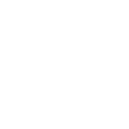

Done.


In [39]:
IMG_START_DATES = ['2010-01-01', '2014-01-01', '2017-01-01', '2017-01-01', '2017-01-01', '2015-01-01']
IMG_END_DATES = ['2011-01-01', '2015-01-01', '2018-01-01', '2018-01-01', '2018-01-01', '2016-01-01']
# !it takes some time to download all the images on the Drive and the storage will reach a limit pretty fast, do not run these function all at once 
# To check the progress you can see the "tasks" section in https://code.earthengine.google.com/
collection_name = 'COPERNICUS_Landcover'
img_collection_index = IMG_COLLECTION_CODES.index(collection_name)
# export_images_collection(square, boundary_filter, collection_name, folder_name_drive, only_download_first_image=True, debug=True, scale=150)
export_images_collection_ROI_lat_long(squares, names, boundary_filter, collection_name, folder_name_drive, only_download_first_image=False, debug=True, scale=150)